# Project 3: Deep & Wide Nets, RNNs, Kernels & Regressions

**Course:** AIM 460 – Group Project #3  
**Team Members:** (fill in names here)  
**Date:** (fill in)

---

## How to Run This Notebook

- **Runtime:** Google Colab → Runtime → Change Runtime Type → set to GPU (T4 or better).
- **Python Version:** 3.10+
- **Libraries Used:**
  - pandas, numpy, matplotlib, seaborn
  - scikit-learn (classical ML, kernels)
  - PyTorch (neural nets, RNNs)
  - requests (API data fetch)
- **Random Seeds:** Fixed at 42 for reproducibility.
- **Output:** All figures/tables are saved under `outputs/`.

Run all cells in order from top to bottom.


In [16]:
# === Install & Import Libraries ===
import sys, subprocess, importlib

def ensure(pkg):
    """Helper: installs pkg if missing."""
    try:
        importlib.import_module(pkg.split("==")[0])
    except ImportError:
        subprocess.run([sys.executable, "-m", "pip", "install", pkg, "-q"], check=False)

# Core packages
for p in [
    "pandas", "numpy", "matplotlib", "seaborn",
    "scikit-learn", "torch", "torchvision", "torchaudio", "requests"
]:
    ensure(p)

# Imports
import os, random, time, gc, warnings
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (8, 5)
sns.set_theme(context="notebook", style="whitegrid")

print("✅ Environment ready.")

✅ Environment ready.


## Reproducibility & Device

This cell:
- Fixes random seeds across Python, NumPy, and PyTorch for reproducibility.
- Chooses **GPU** if available (for neural nets).


In [17]:
# === Seeds & Device ===
RANDOM_STATE = 42

def set_all_seeds(seed=RANDOM_STATE):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

Using device: cpu


## 2) Data Gathering & Description

**Goal:** Collect two original datasets (≥ 3,000 rows, ≥ 5 features). At least **one** must be collected via an **API**.  
We will use:
- **Dataset A (API):** NYC Motor Vehicle Collisions (Socrata API).
- **Dataset B (CSV/URL):** `vehicles_slim_2020plus.csv` (vehicle-level).

**What this section does:**
1. Fetch Dataset A via API and save to `dataset_a.csv`.
2. Load Dataset B from GitHub raw and save to `dataset_b.csv`.
3. Show raw samples and basic shapes.
4. Perform initial **cleaning + preprocessing + EDA**:
   - Missingness audit with plots
   - IQR-based outlier flags (not dropping, just flagging)
   - Imputation choices (numeric median, categorical mode)
   - Rationale for encoding (one-hot) and scaling (standardization)

> After running, write **2–3 sentences** about data engineering challenges you encountered (rate limits, inconsistent timestamps, mixed types, etc.).


In [18]:
# === Config for data sources & output ===
from pathlib import Path
import os, json, time, requests
import pandas as pd
import numpy as np

OUT_DIR = Path("outputs"); OUT_DIR.mkdir(exist_ok=True)

# Dataset A (API): NYC Open Data collisions (Socrata)
# We select a subset of useful crash-level columns and limit >= 3000 rows.
# You can increase $limit if you want more data.
API_URL_A = "https://data.cityofnewyork.us/resource/h9gi-nx95.csv"
API_PARAMS = {
    "$limit": 40000,  # increase if you want more
    "$select": ",".join([
        "collision_id","crash_date","crash_time","borough","zip_code","latitude","longitude",
        "number_of_persons_injured","number_of_persons_killed",
        "number_of_cyclist_injured","number_of_motorist_injured","number_of_pedestrians_injured",
        "on_street_name","cross_street_name"
    ]),
    # optionally restrict date range:
    # "$where": "crash_date >= '2020-01-01T00:00:00.000'"
}
SOCRATA_APP_TOKEN = os.getenv("SOCRATA_APP_TOKEN", None)  # optional

# Dataset B (CSV/URL): vehicles_slim_2020plus
URL_B = "https://raw.githubusercontent.com/0tylerjames0/AIM460_GP3/refs/heads/main/vehicles_slim_2020plus.csv"

A_PATH = Path("dataset_a.csv")
B_PATH = Path("dataset_b.csv")

### Fetch Dataset A via API (NYC collisions)

This cell:
- Calls the **Socrata API** to fetch crash-level data.
- Saves it to `dataset_a.csv`.
- Prints row count and shows a small sample.

If you hit a rate-limit, re-run or set an `SOCRATA_APP_TOKEN` in the environment.

In [19]:
headers = {"X-App-Token": SOCRATA_APP_TOKEN} if SOCRATA_APP_TOKEN else {}
try:
    r = requests.get(API_URL_A, params=API_PARAMS, headers=headers, timeout=90)
    r.raise_for_status()
    A_PATH.write_bytes(r.content)
    print(f"✅ Downloaded Dataset A -> {A_PATH.resolve()}")
except Exception as e:
    print("⚠️ API fetch failed:", e)
    print("If offline/limited, place a CSV named 'dataset_a.csv' in the working directory.")

# Load to confirm
df_a_raw = None
try:
    df_a_raw = pd.read_csv(A_PATH, low_memory=False, parse_dates=["crash_date"])
    print("Dataset A shape:", df_a_raw.shape)
    display(df_a_raw.head(5))
except Exception as e:
    print("⚠️ Could not read dataset_a.csv:", e)

✅ Downloaded Dataset A -> /content/dataset_a.csv
Dataset A shape: (40000, 14)


,collision_id,crash_date,crash_time,borough,zip_code,latitude,longitude,number_of_persons_injured,number_of_persons_killed,number_of_cyclist_injured,number_of_motorist_injured,number_of_pedestrians_injured,on_street_name,cross_street_name
0,4455765,2021-09-11,2:39,NaN,NaN,NaN,NaN,2,0,0,2,0,WHITESTONE EXPRESSWAY,NaN
1,4513547,2022-03-26,11:45,NaN,NaN,NaN,NaN,1,0,0,1,0,QUEENSBORO BRIDGE UPPER,NaN
2,4675373,2023-11-01,1:29,BROOKLYN,11230.0,40.62179,-73.970024,1,0,0,1,0,OCEAN PARKWAY,NaN
3,4541903,2022-06-29,6:55,NaN,NaN,NaN,NaN,0,0,0,0,0,THROGS NECK BRIDGE,NaN
4,4566131,2022-09-21,13:21,NaN,NaN,NaN,NaN,0,0,0,0,0,BROOKLYN BRIDGE,NaN


### Load Dataset B from GitHub raw (vehicles table)

This cell:
- Downloads the vehicle-level table from your GitHub repo.
- Saves as `dataset_b.csv`.
- Prints row count and shows a small sample.

This dataset links to the crash table via `collision_id`.


In [20]:
import io
import requests

try:
    r = requests.get(URL_B, timeout=90)
    r.raise_for_status()
    B_PATH.write_bytes(r.content)
    print(f"✅ Downloaded Dataset B -> {B_PATH.resolve()}")
except Exception as e:
    print("⚠️ Download failed:", e)
    print("If offline, place a CSV named 'dataset_b.csv' in the working directory.")

df_b_raw = None
try:
    df_b_raw = pd.read_csv(B_PATH, low_memory=False, parse_dates=["crash_date"])
    print("Dataset B shape:", df_b_raw.shape)
    display(df_b_raw.head(5))
except Exception as e:
    print("⚠️ Could not read dataset_b.csv:", e)

✅ Downloaded Dataset B -> /content/dataset_b.csv
Dataset B shape: (50000, 24)


,collision_id,crash_date,crash_time,state_registration,vehicle_type,vehicle_make,travel_direction,vehicle_occupants,driver_sex,driver_license_status,...,vehicle_damage_1,vehicle_damage_2,vehicle_damage_3,contributing_factor_1,contributing_factor_2,hour,dow,month,injury_flag,number_of_persons_injured
0,4267580,2020-01-01,2:44,NY,Sedan,HOND -CAR/SUV,South,1.0,M,Licensed,...,Center Front End,Right Front Bumper,NaN,Unspecified,Unspecified,2,2,1,0,0.0
1,4267808,2020-01-01,15:05,MI,Sedan,MITS -CAR/SUV,East,1.0,F,Licensed,...,Right Rear Bumper,No Damage,No Damage,Driver Inattention/Distraction,Backing Unsafely,15,2,1,0,0.0
2,4267808,2020-01-01,15:05,NY,Sedan,BMW -CAR/SUV,Unknown,1.0,F,Licensed,...,No Damage,No Damage,No Damage,Unspecified,Unspecified,15,2,1,0,0.0
3,4363648,2020-01-01,6:20,NY,Station Wagon/Sport Utility Vehicle,MERZ -CAR/SUV,North,0.0,NaN,NaN,...,Left Rear Quarter Panel,Left Side Doors,Left Front Quarter Panel,Unspecified,Unspecified,6,2,1,0,0.0
4,4363648,2020-01-01,6:20,NJ,Sedan,NISS -CAR/SUV,North,0.0,NaN,NaN,...,Left Side Doors,Left Front Quarter Panel,Left Front Bumper,Unspecified,Unspecified,6,2,1,0,0.0


### Data Engineering Notes (write 2–3 sentences)

- API quirks (rate limits, schema drift, mixed types, timestamps):  
  _e.g., Socrata rows sometimes have missing borough; times come as HH:MM strings; `collision_id` is numeric-as-text_.
- File consistency (header names, encoding, unexpected nulls):  
  _e.g., `zip_code` sometimes missing; lat/long blank for some rows_.

> We will address missingness, outliers, and types in the next cells.


### Initial Description & Type Audit

This cell prints:
- Shapes and column counts
- Dtypes (to catch numeric-vs-text issues)
- Quick frequency table of `borough` and example injury totals


In [21]:
def quick_profile(df, name="DF"):
    print(f"=== {name} ===")
    print("Shape:", df.shape)
    dtypes = df.dtypes.value_counts()
    print("Dtype counts:\n", dtypes)
    display(df.dtypes.to_frame("dtype").T)
    if "borough" in df.columns:
        print("\nTop borough counts:")
        display(df["borough"].value_counts(dropna=False).head(10))
    inj_cols = [c for c in df.columns if "injur" in c.lower()]
    if inj_cols:
        print("\nSample injury columns:", inj_cols[:5])
        display(df[inj_cols].head(3))

if df_a_raw is not None: quick_profile(df_a_raw, "Dataset A (raw)")
if df_b_raw is not None: quick_profile(df_b_raw, "Dataset B (raw)")


=== Dataset A (raw) ===
Shape: (40000, 14)
Dtype counts:
 int64             6
object            4
float64           3
datetime64[ns]    1
Name: count, dtype: int64


,collision_id,crash_date,crash_time,borough,zip_code,latitude,longitude,number_of_persons_injured,number_of_persons_killed,number_of_cyclist_injured,number_of_motorist_injured,number_of_pedestrians_injured,on_street_name,cross_street_name
dtype,int64,datetime64[ns],object,object,float64,float64,float64,int64,int64,int64,int64,int64,object,object



Top borough counts:


,count
borough,
NaN,13794
BROOKLYN,9139
QUEENS,7016
BRONX,4821
MANHATTAN,4270
STATEN ISLAND,960



Sample injury columns: ['number_of_persons_injured', 'number_of_cyclist_injured', 'number_of_motorist_injured', 'number_of_pedestrians_injured']


,number_of_persons_injured,number_of_cyclist_injured,number_of_motorist_injured,number_of_pedestrians_injured
0,2,0,2,0
1,1,0,1,0
2,1,0,1,0


=== Dataset B (raw) ===
Shape: (50000, 24)
Dtype counts:
 object            16
int64              5
float64            2
datetime64[ns]     1
Name: count, dtype: int64


,collision_id,crash_date,crash_time,state_registration,vehicle_type,vehicle_make,travel_direction,vehicle_occupants,driver_sex,driver_license_status,...,vehicle_damage_1,vehicle_damage_2,vehicle_damage_3,contributing_factor_1,contributing_factor_2,hour,dow,month,injury_flag,number_of_persons_injured
dtype,int64,datetime64[ns],object,object,object,object,object,float64,object,object,...,object,object,object,object,object,int64,int64,int64,int64,float64



Sample injury columns: ['injury_flag', 'number_of_persons_injured']


,injury_flag,number_of_persons_injured
0,0,0.0
1,0,0.0
2,0,0.0


### Missingness & Basic EDA (charts)

This cell draws:
- **Missingness bar** (top 25 most-missing columns)
- **Numeric histograms** (shape of distributions)
- **Boxplots** for first few numeric columns (spot outliers)
- **Correlation heatmap** (numerics only)

> These visuals inform imputation choices and highlight skew/outliers.

=== Dataset A (raw) (shape=(40000, 14)) ===


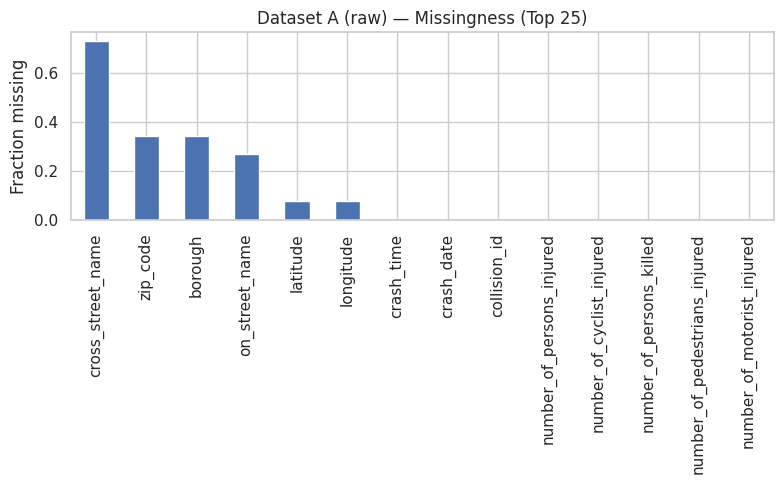

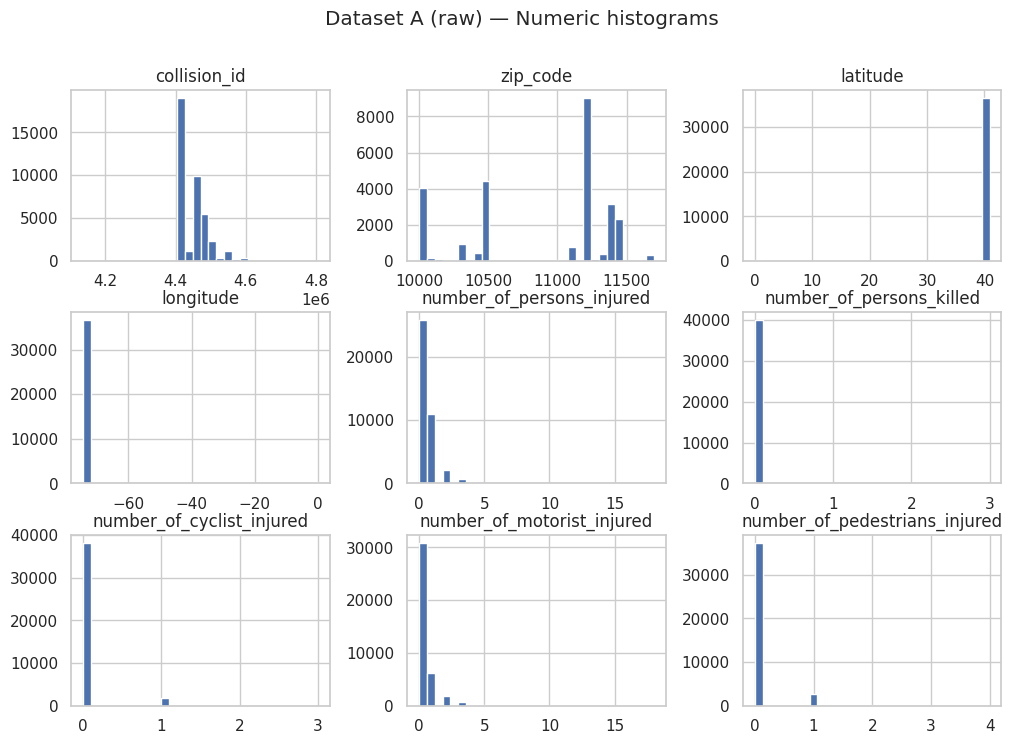

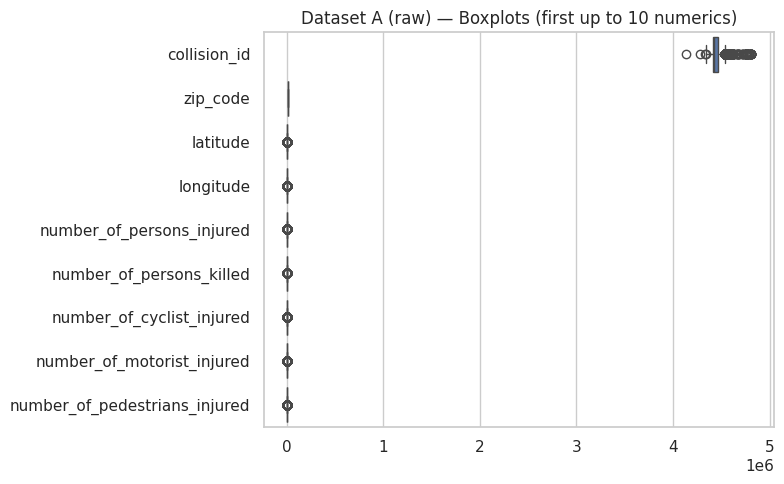

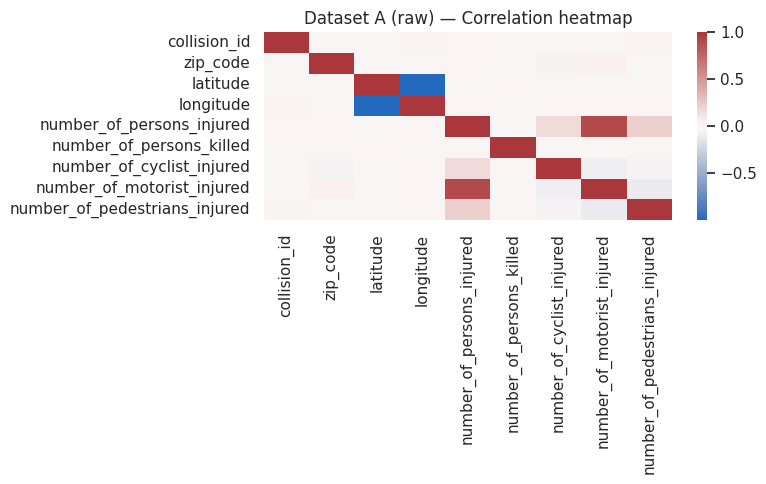

=== Dataset B (raw) (shape=(50000, 24)) ===


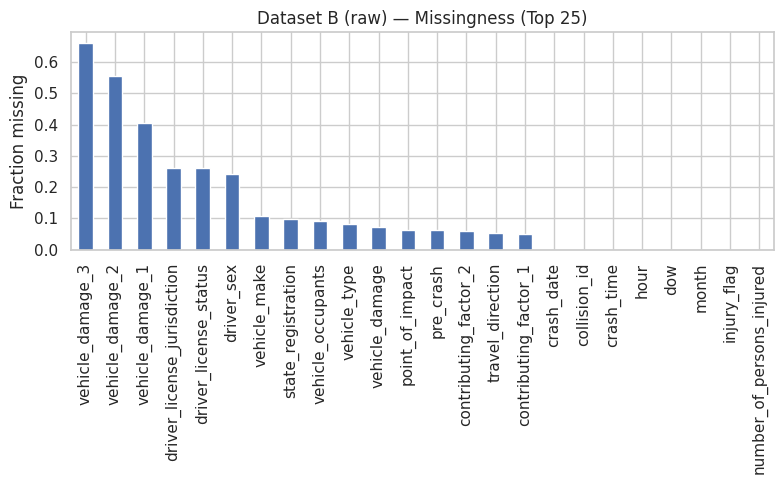

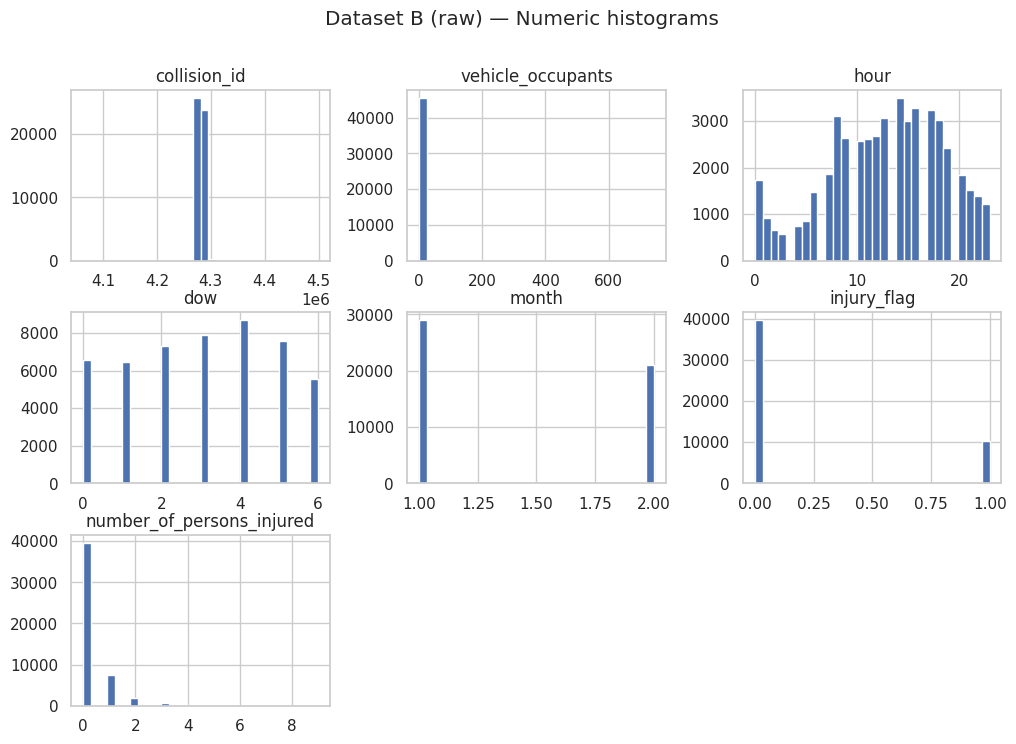

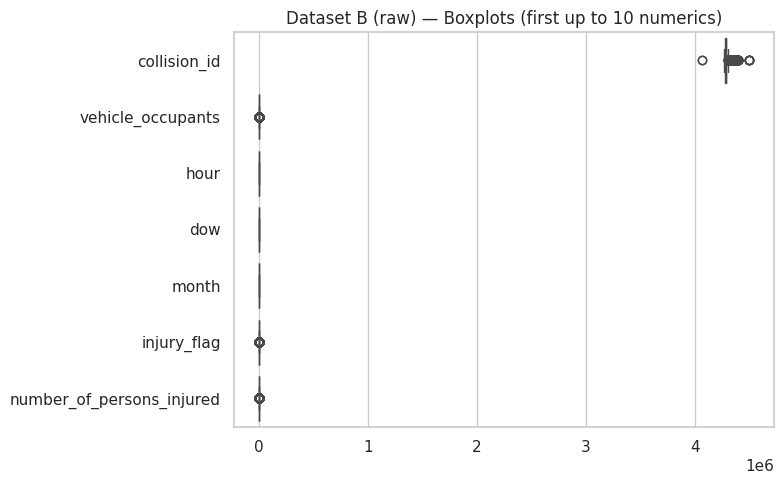

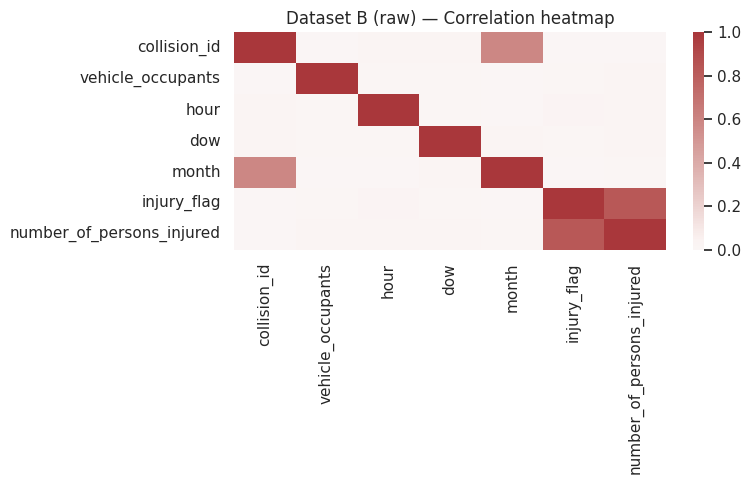

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def eda_charts(df, name="DF"):
    print(f"=== {name} (shape={df.shape}) ===")
    # Missingness bar
    miss = df.isna().mean().sort_values(ascending=False)
    ax = miss.head(25).plot(kind="bar")
    ax.set_title(f"{name} — Missingness (Top 25)")
    ax.set_ylabel("Fraction missing")
    plt.tight_layout(); plt.show()

    # Numeric histograms & boxplots
    num = df.select_dtypes(include=[np.number])
    if not num.empty:
        num.hist(bins=30, figsize=(12,8))
        plt.suptitle(f"{name} — Numeric histograms"); plt.show()

        cols = num.columns[:10]
        if len(cols) > 0:
            sns.boxplot(data=num[cols], orient="h")
            plt.title(f"{name} — Boxplots (first up to 10 numerics)")
            plt.tight_layout(); plt.show()

        # Correlation heatmap
        corr = num.corr(numeric_only=True)
        sns.heatmap(corr, cmap="vlag", center=0)
        plt.title(f"{name} — Correlation heatmap")
        plt.tight_layout(); plt.show()

if df_a_raw is not None: eda_charts(df_a_raw, "Dataset A (raw)")
if df_b_raw is not None: eda_charts(df_b_raw, "Dataset B (raw)")


### Cleaning & IQR Outlier Flags

Approach:
1. **Drop very-sparse columns** (≥ 60% missing).
2. **Add outlier flags** using IQR per numeric column.  
   We keep outliers (no dropping) and expose them as `__outlier` binary features.

> This preserves potentially informative extremes while letting models learn from flagged points.


In [23]:
def drop_sparse(df, thr=0.60):
    return df.loc[:, df.isna().mean() <= thr]

def add_iqr_flags(df, k=1.5):
    df = df.copy()
    for c in df.select_dtypes(include=[np.number]).columns:
        Q1, Q3 = df[c].quantile(0.25), df[c].quantile(0.75)
        IQR = Q3 - Q1
        low, high = Q1 - k*IQR, Q3 + k*IQR
        df[f"{c}__outlier"] = ((df[c] < low) | (df[c] > high)).astype(int)
    return df

df_a = drop_sparse(df_a_raw) if df_a_raw is not None else None
df_b = drop_sparse(df_b_raw) if df_b_raw is not None else None

if df_a is not None: df_a = add_iqr_flags(df_a, 1.5)
if df_b is not None: df_b = add_iqr_flags(df_b, 1.5)

print("Post-clean shapes:",
      None if df_a is None else df_a.shape,
      None if df_b is None else df_b.shape)

Post-clean shapes: (40000, 22) (50000, 30)


### Imputation (Preview) + Encoding/Scaling Rationale

**Imputation choices (used now to create clean tables for EDA continuity):**
- **Numeric:** median (robust to outliers)
- **Categorical:** most frequent value

**Encoding/Scaling (used later in modeling pipelines):**
- **One-Hot Encoding** for categorical features (lets linear & kernel methods work).
- **Standardization** for numerics (stabilizes optimization, good for kernels/NNs).

This cell applies **simple imputation now** to produce `_clean` tables for EDA continuity.  
Final models will still use full pipelines with imputation inside `ColumnTransformer`.

Clean tables ready: A B
=== Dataset A (clean, imputed preview) (shape=(40000, 22)) ===


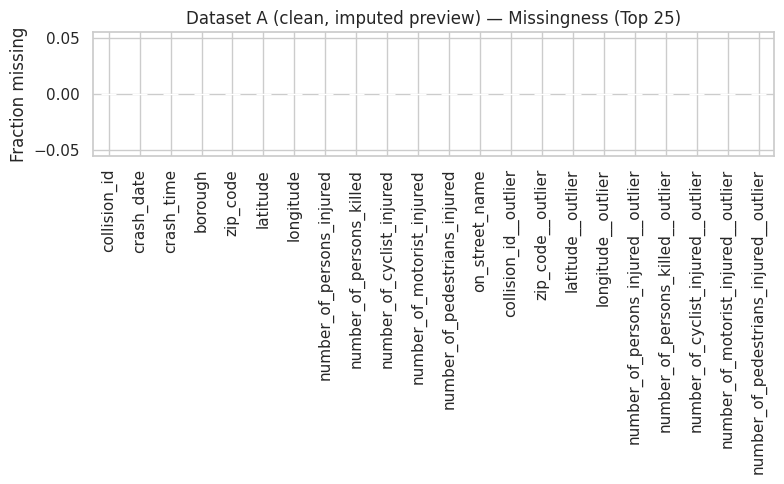

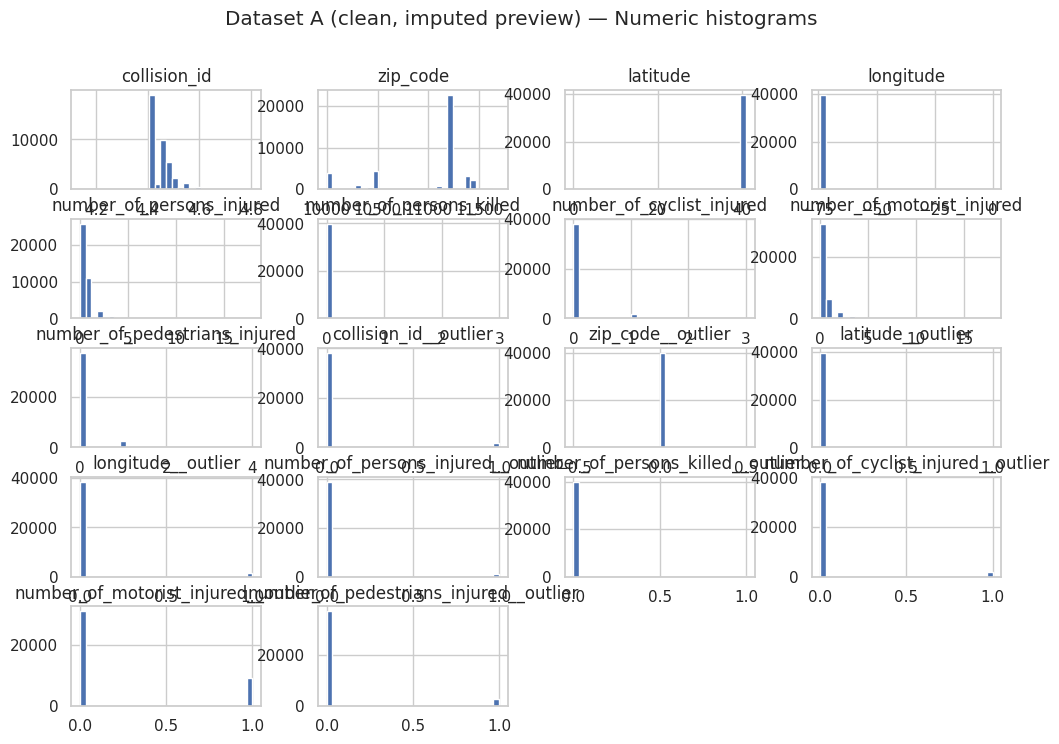

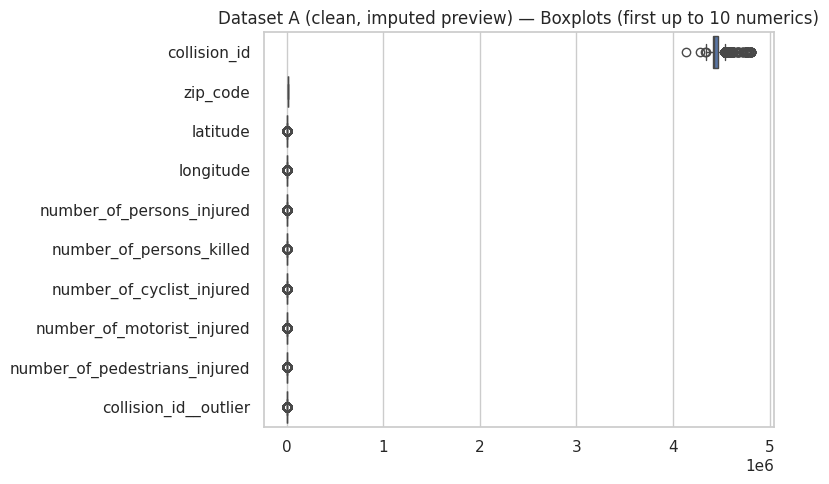

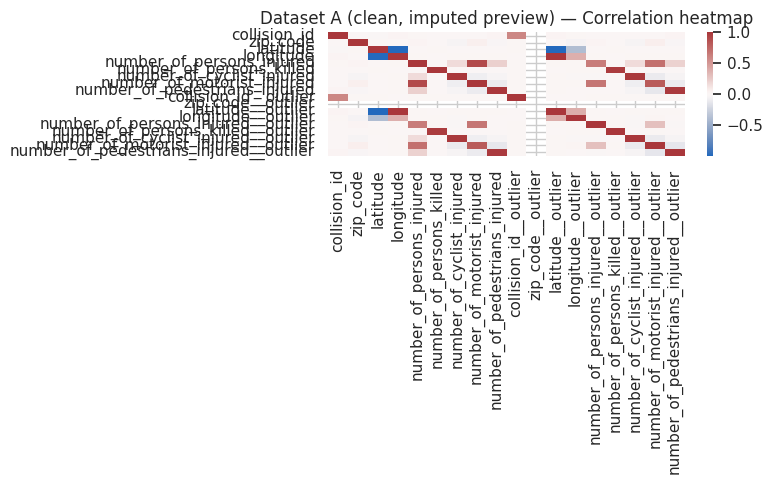

=== Dataset B (clean, imputed preview) (shape=(50000, 30)) ===


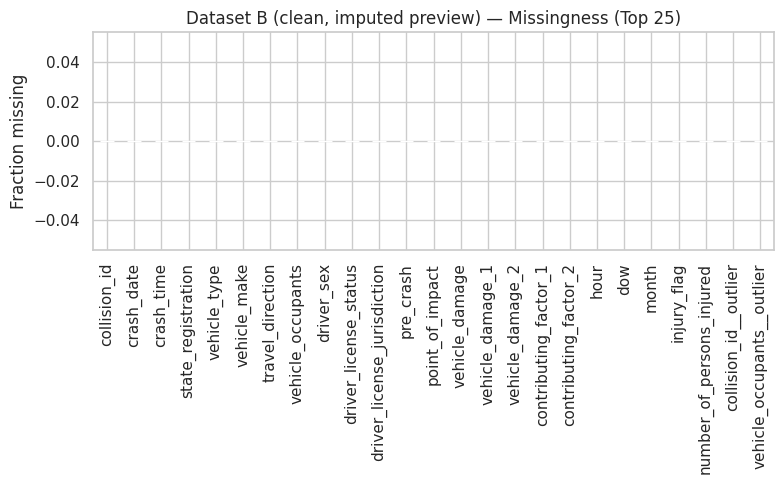

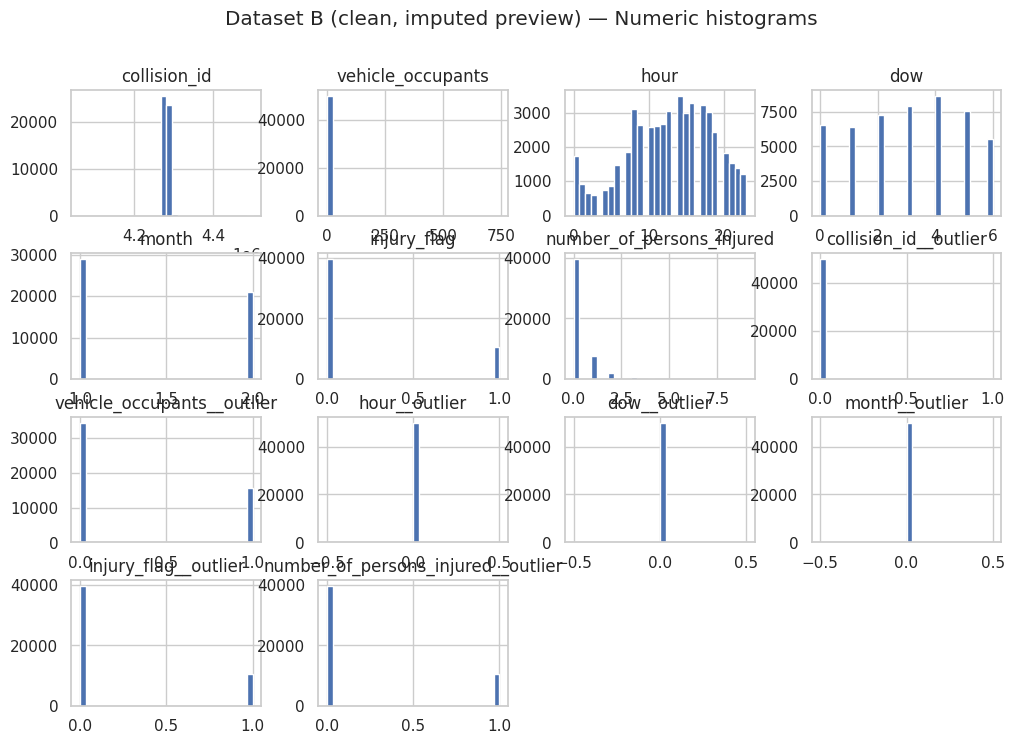

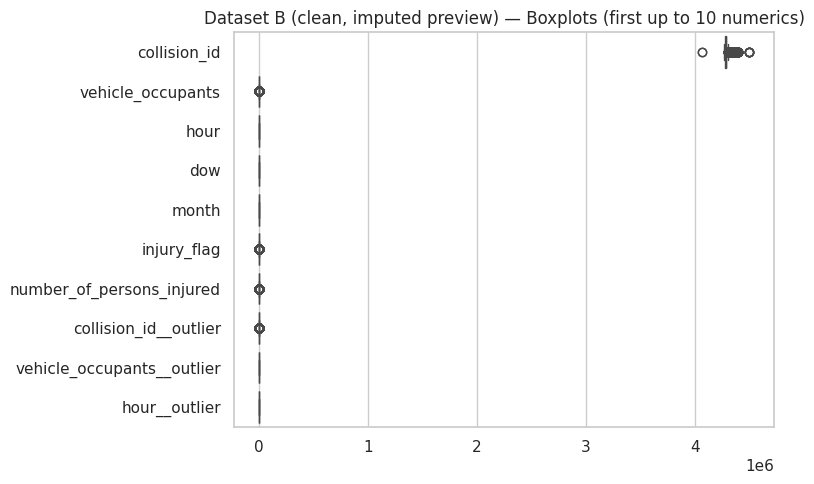

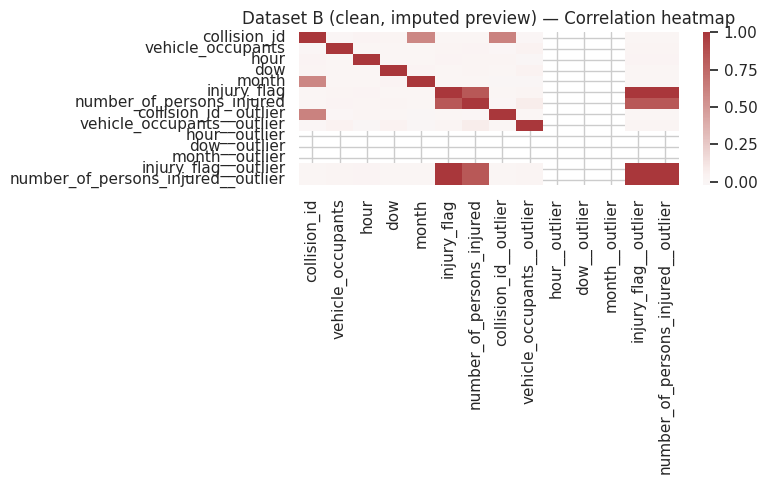

In [24]:
from sklearn.impute import SimpleImputer

def simple_impute_df(df):
    df = df.copy()
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    cat_cols = [c for c in df.columns if c not in num_cols]

    if num_cols:
        df[num_cols] = SimpleImputer(strategy="median").fit_transform(df[num_cols])
    if cat_cols:
        df[cat_cols] = SimpleImputer(strategy="most_frequent").fit_transform(df[cat_cols])
    return df

df_a_clean = simple_impute_df(df_a) if df_a is not None else None
df_b_clean = simple_impute_df(df_b) if df_b is not None else None

print("Clean tables ready:",
      "A" if df_a_clean is not None else "-",
      "B" if df_b_clean is not None else "-")

# Quick post-imputation EDA (optional)
if df_a_clean is not None:
    eda_charts(df_a_clean, "Dataset A (clean, imputed preview)")
if df_b_clean is not None:
    eda_charts(df_b_clean, "Dataset B (clean, imputed preview)")

### Section 2 Wrap-Up (What to submit/commit)

- **Data Scripts/Links:**  
  - API fetch (Socrata params) and CSV saves are included above — commit these steps/links in your repo.
- **Samples:**  
  - Raw previews have been shown via `head()`; charts capture missingness/outliers.
- **Challenges (write-up prompt):**  
  - Note any API throttling, mixed types (`collision_id` as string vs int), time parsing (`crash_time`), or location gaps.

**Next:** Section 3 will merge vehicles ↔ crashes, define the **regression target** (`number_of_persons_injured`), and build preprocessing for models.


## 3) Feature Engineering

**Goals in this section**
1. **Merge** crash-level (Dataset A) with vehicle-level (Dataset B) on `collision_id`.
2. Define the **regression target**: `number_of_persons_injured` (numeric count).
3. Create **≥3 domain-driven features**:
   - Temporal: `hour`, `dow` (day of week), `month`
   - Vehicle context: `vehicles_per_crash`, share of each vehicle type per crash
   - Factors: counts of contributing factors per crash
4. Visualize target & key engineered features:
   - Target histogram + KDE
   - `vehicles_per_crash` distribution
   - Target by `borough` (boxplot)
   - Spearman correlations with target (numerics)

> We keep outlier flags from Section 2. We **do not** one-hot or scale yet — that happens inside modeling pipelines.

In [25]:
# === Merge by collision_id & build target ===

df_a2 = df_a_clean.copy() if df_a_clean is not None else None
df_b2 = df_b_clean.copy() if df_b_clean is not None else None

assert df_a2 is not None and df_b2 is not None, "Section 2 must load & clean both datasets."

# Ensure collision_id is numeric & comparable
for d in (df_a2, df_b2):
    if "collision_id" not in d.columns:
        raise KeyError("collision_id missing in one dataset.")
    d["collision_id"] = pd.to_numeric(d["collision_id"], errors="coerce").astype("Int64")

# Compute vehicle aggregates per crash
veh_grp = df_b2.groupby("collision_id")

# Basic vehicle count per crash
veh_count = veh_grp.size().rename("vehicles_per_crash")

# Vehicle type proportions (top few)
veh_type_col = None
for cand in ["vehicle_type", "vehicle_type_code1", "vehicle_type_code", "vehicle_type_name"]:
    if cand in df_b2.columns:
        veh_type_col = cand; break

veh_share = None
if veh_type_col:
    tmp = (df_b2.assign(_ones=1)
                  .pivot_table(index="collision_id", columns=veh_type_col, values="_ones", aggfunc="sum", fill_value=0))
    tmp = tmp.div(tmp.sum(axis=1).replace(0, np.nan), axis=0)
    # keep top 5 most common types for compactness
    top_types = tmp.sum().sort_values(ascending=False).head(5).index
    veh_share = tmp[top_types]
    veh_share.columns = [f"veh_share__{c}" for c in veh_share.columns]

# Contributing factor counts (if present)
factor_cols = [c for c in df_b2.columns if "factor" in c.lower()]
factor_count = None
if factor_cols:
    # count non-empty factors per crash
    fac = df_b2[factor_cols].notna().astype(int)
    factor_count = fac.groupby(df_b2["collision_id"]).sum()
    # collapse to a single count column = rows in which ANY factor was present
    factor_any = fac.any(axis=1).astype(int).groupby(df_b2["collision_id"]).sum().rename("factor_any_count")

# Join aggregates back to crash table
cr = df_a2.set_index("collision_id")
cr = cr.join(veh_count, how="left")
if veh_share is not None:
    cr = cr.join(veh_share, how="left")
if factor_cols:
    cr = cr.join(factor_any, how="left")

cr["vehicles_per_crash"] = cr["vehicles_per_crash"].fillna(0)
if "factor_any_count" in cr.columns:
    cr["factor_any_count"] = cr["factor_any_count"].fillna(0)

# Temporal features from crash_time / crash_date
if "crash_time" in cr.columns:
    t = pd.to_datetime(cr["crash_time"], format="%H:%M", errors="coerce")
    cr["hour"] = t.dt.hour
if "crash_date" in cr.columns:
    dt = pd.to_datetime(cr["crash_date"], errors="coerce")
    cr["dow"] = dt.dt.dayofweek
    cr["month"] = dt.dt.month

# Define target
assert "number_of_persons_injured" in cr.columns, "Target column 'number_of_persons_injured' missing."
cr = cr.dropna(subset=["number_of_persons_injured"]).copy()
cr["number_of_persons_injured"] = pd.to_numeric(cr["number_of_persons_injured"], errors="coerce")
cr = cr.dropna(subset=["number_of_persons_injured"])

# Final engineered table
eng = cr.reset_index()
print("Engineered dataset shape:", eng.shape)
display(eng.head(5))


Engineered dataset shape: (40000, 32)


,collision_id,crash_date,crash_time,borough,zip_code,latitude,longitude,number_of_persons_injured,number_of_persons_killed,number_of_cyclist_injured,...,vehicles_per_crash,veh_share__Sedan,veh_share__Station Wagon/Sport Utility Vehicle,veh_share__Taxi,veh_share__Pick-up Truck,veh_share__Box Truck,factor_any_count,hour,dow,month
0,4455765,2021-09-11,2:39,BROOKLYN,11208.0,40.71307,-73.919975,2.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,2,5,9
1,4513547,2022-03-26,11:45,BROOKLYN,11208.0,40.71307,-73.919975,1.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,11,5,3
2,4675373,2023-11-01,1:29,BROOKLYN,11230.0,40.62179,-73.970024,1.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,1,2,11
3,4541903,2022-06-29,6:55,BROOKLYN,11208.0,40.71307,-73.919975,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,6,2,6
4,4566131,2022-09-21,13:21,BROOKLYN,11208.0,40.71307,-73.919975,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,13,2,9


### Target & Feature Visuals

This cell draws:
- **Target distribution** (`number_of_persons_injured`)
- **vehicles_per_crash** histogram
- **Target by borough** (boxplot) to capture location effect
- **Spearman correlation** of numeric features with the target (bar chart)

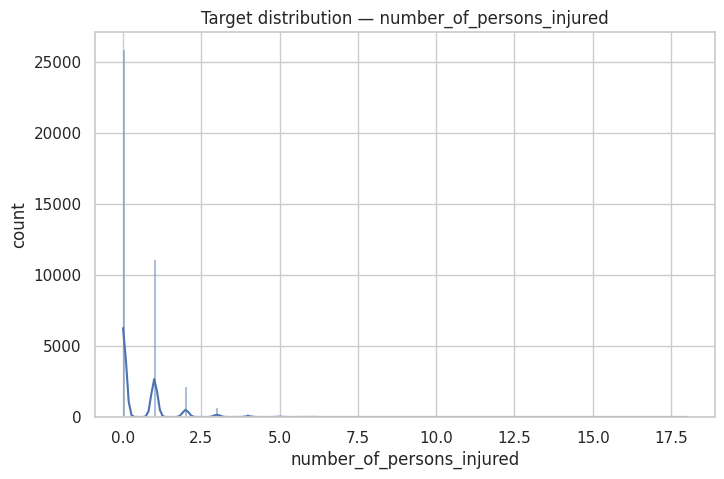

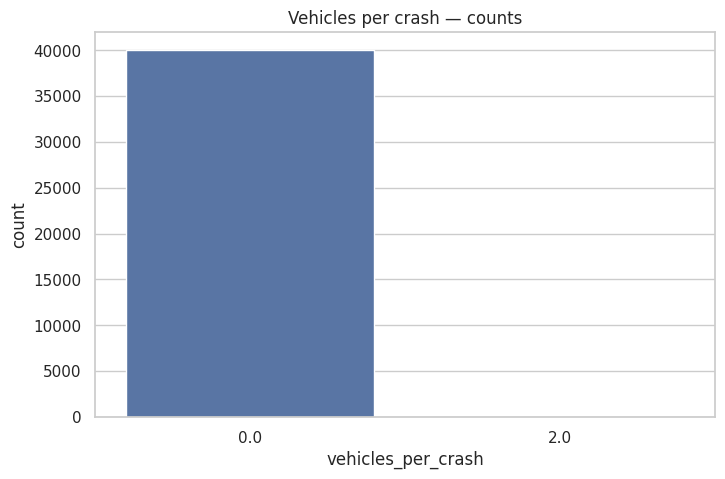

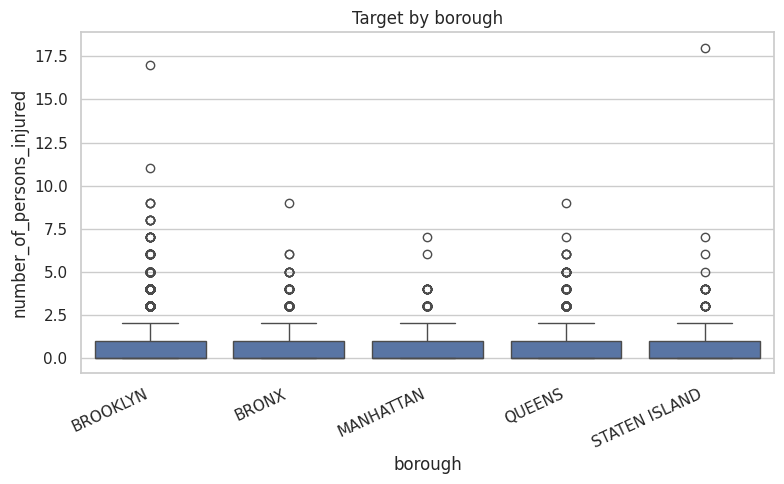

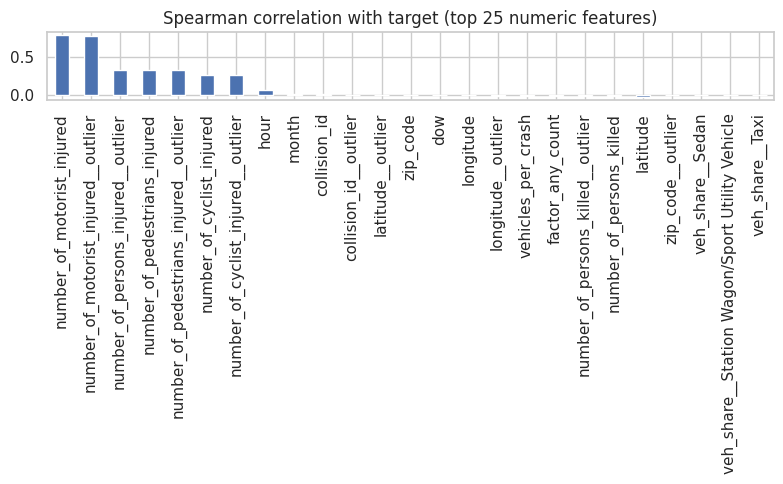

In [26]:
# Charts for engineered features & target
target = "number_of_persons_injured"

# 1) Target distribution
sns.histplot(eng[target], kde=True)
plt.title("Target distribution — number_of_persons_injured")
plt.xlabel(target); plt.ylabel("count")
plt.show()

# 2) vehicles_per_crash distribution
if "vehicles_per_crash" in eng.columns:
    sns.countplot(x="vehicles_per_crash", data=eng)
    plt.title("Vehicles per crash — counts")
    plt.show()

# 3) Target by borough
if "borough" in eng.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(data=eng, x="borough", y=target)
    plt.title("Target by borough")
    plt.xticks(rotation=25, ha="right")
    plt.tight_layout(); plt.show()

# 4) Spearman correlation with target (numeric cols only)
num_cols = [c for c in eng.columns if pd.api.types.is_numeric_dtype(eng[c])]
corr = eng[num_cols].corr(method="spearman")[target].sort_values(ascending=False)
corr = corr.drop(labels=[target], errors="ignore")
corr.head(25).plot(kind="bar")
plt.title("Spearman correlation with target (top 25 numeric features)")
plt.tight_layout(); plt.show()

### Train/Test split & Column typing (for later sections)

We now:
- Separate **features (X)** and **target (y)**.
- Split into **train/test**.
- Identify numeric vs categorical columns for the `ColumnTransformer` used in modeling.


### Emergency rebuild of `eng` (only needed after a crash)
If the runtime reset and `eng` is missing, this cell reconstructs the engineered
table from the saved CSVs. Then Cell 26 (train/test split) will work again.


In [27]:
# Rebuild `eng` from saved CSVs so Cell 26 can run even after a crash.

import pandas as pd
import numpy as np

# 1) Load cleaned sources (or raw -> simple-impute) from disk
A_PATH = "dataset_a.csv"
B_PATH = "dataset_b.csv"

df_a = pd.read_csv(A_PATH, low_memory=False, parse_dates=["crash_date"])
df_b = pd.read_csv(B_PATH, low_memory=False, parse_dates=["crash_date"])

# Simple impute to ensure merge works after a crash
from sklearn.impute import SimpleImputer
def simple_impute_df(df):
    df = df.copy()
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    cat_cols = [c for c in df.columns if c not in num_cols]
    if num_cols:
        df[num_cols] = SimpleImputer(strategy="median").fit_transform(df[num_cols])
    if cat_cols:
        df[cat_cols] = SimpleImputer(strategy="most_frequent").fit_transform(df[cat_cols])
    return df

df_a = simple_impute_df(df_a)
df_b = simple_impute_df(df_b)

# 2) Keys & types
for d in (df_a, df_b):
    d["collision_id"] = pd.to_numeric(d["collision_id"], errors="coerce").astype("Int64")

# 3) Vehicle aggregates
veh_grp = df_b.groupby("collision_id", dropna=True)
veh_count = veh_grp.size().rename("vehicles_per_crash")

veh_type_col = None
for cand in ["vehicle_type", "vehicle_type_code1", "vehicle_type_code", "vehicle_type_name"]:
    if cand in df_b.columns:
        veh_type_col = cand; break

veh_share = None
if veh_type_col:
    tmp = (df_b.assign(_ones=1)
              .pivot_table(index="collision_id", columns=veh_type_col,
                           values="_ones", aggfunc="sum", fill_value=0))
    tmp = tmp.div(tmp.sum(axis=1).replace(0, np.nan), axis=0)
    top_types = tmp.sum().sort_values(ascending=False).head(5).index
    veh_share = tmp[top_types]
    veh_share.columns = [f"veh_share__{c}" for c in veh_share.columns]

factor_cols = [c for c in df_b.columns if "factor" in c.lower()]
factor_any_count = None
if factor_cols:
    fac = df_b[factor_cols].notna().any(axis=1).astype(int)
    factor_any_count = fac.groupby(df_b["collision_id"]).sum().rename("factor_any_count")

# 4) Join back to crashes
cr = df_a.set_index("collision_id")
cr = cr.join(veh_count, how="left")
if veh_share is not None:
    cr = cr.join(veh_share, how="left")
if factor_any_count is not None:
    cr = cr.join(factor_any_count, how="left")

cr["vehicles_per_crash"] = cr["vehicles_per_crash"].fillna(0)
if "factor_any_count" in cr.columns:
    cr["factor_any_count"] = cr["factor_any_count"].fillna(0)

# 5) Temporal features
if "crash_time" in cr.columns:
    t = pd.to_datetime(cr["crash_time"], format="%H:%M", errors="coerce")
    cr["hour"] = t.dt.hour
if "crash_date" in cr.columns:
    dt = pd.to_datetime(cr["crash_date"], errors="coerce")
    cr["dow"] = dt.dt.dayofweek
    cr["month"] = dt.dt.month

# 6) Target
assert "number_of_persons_injured" in cr.columns, \
    "Target `number_of_persons_injured` missing in dataset_a.csv"
cr["number_of_persons_injured"] = pd.to_numeric(cr["number_of_persons_injured"], errors="coerce")
cr = cr.dropna(subset=["number_of_persons_injured"])

# 7) Final engineered frame `eng`
eng = cr.reset_index()
print("Rebuilt `eng` shape:", eng.shape)
display(eng.head(3)[["collision_id","borough","vehicles_per_crash","factor_any_count",
                     "hour","dow","month","number_of_persons_injured"]].head(3))

Rebuilt `eng` shape: (40000, 24)


,collision_id,borough,vehicles_per_crash,factor_any_count,hour,dow,month,number_of_persons_injured
0,4455765,BROOKLYN,0.0,0.0,2,5,9,2.0
1,4513547,BROOKLYN,0.0,0.0,11,5,3,1.0
2,4675373,BROOKLYN,0.0,0.0,1,2,11,1.0


In [28]:
# === Cell 26 — Train/Test split (must be run BEFORE Cell 28) ===
assert 'eng' in globals(), "Run your merge/feature-engineering cells to create `eng` first."

TARGET = "number_of_persons_injured"
assert TARGET in eng.columns, f"Missing target column `{TARGET}` in eng."

drop_cols = {TARGET, "collision_id"} & set(eng.columns)
X = eng.drop(columns=list(drop_cols)).copy()
y = eng[TARGET].astype(float).copy()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

print("Split OK -> X_train:", X_train.shape, "| X_test:", X_test.shape)


Split OK -> X_train: (32000, 22) | X_test: (8000, 22)


### Recompute column types and build the preprocessor

After the split (Cell 26), we re-derive numeric vs. categorical columns and
rebuild the `ColumnTransformer` with One-Hot + StandardScaler. This ensures
`cat_cols` and `num_cols` are always defined.


In [29]:
# Recompute numeric and categorical feature lists
num_cols = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
cat_cols = [c for c in X_train.columns if c not in num_cols]

print(f"Numeric features: {len(num_cols)}")
print(f"Categorical features: {len(cat_cols)}")

# Preprocessor
import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# If you want max precision (keeps all categories, high RAM):
#   ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
# Safer version (buckets rare categories to save RAM):
ohe = OneHotEncoder(handle_unknown="infrequent_if_exist", min_frequency=5, sparse_output=True)

pre = ColumnTransformer(
    transformers=[
        ("cat", Pipeline(steps=[
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ohe", ohe),
        ]), cat_cols),
        ("num", Pipeline(steps=[
            ("imp", SimpleImputer(strategy="median")),
            ("sc", StandardScaler(with_mean=False)),
        ]), num_cols),
    ],
    remainder="drop",
)

print("✅ Preprocessor built.")

Numeric features: 17
Categorical features: 5
✅ Preprocessor built.


### Error vs Hyperparameters (plots)

We visualize how validation MSE changes across the sweeps:
- Ridge / LASSO / ElasticNet: line plots of MSE vs sweep index
- Kernel Ridge (RBF): **heatmap** over (alpha × gamma)
- Kernel Ridge (Poly): **heatmap** over (alpha × degree)

> These plots help justify chosen hyperparameters.


In [30]:
# Recompute Ridge / LASSO / ElasticNet sweeps if not already present.
# Requires: X_train, y_train, X_test, y_test, and `pre` from Cell 28.

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import itertools, time
import pandas as pd
import numpy as np

def fit_eval(model, label):
    pipe = Pipeline([("pre", pre), ("model", model)])
    t0 = time.time(); pipe.fit(X_train, y_train); tr = time.time() - t0
    pred = pipe.predict(X_test)
    return {
        "model": label,
        "val_mse": mean_squared_error(y_test, pred),
        "val_r2":  r2_score(y_test, pred),
        "train_sec": tr
    }, pipe

def sweep(model_ctor, grid, label):
    rows, best = [], (None, np.inf, None)
    keys = list(grid.keys())
    for vals in itertools.product(*[grid[k] for k in keys]):
        params = dict(zip(keys, vals))
        row, pipe = fit_eval(model_ctor(**params), f"{label} {params}")
        rows.append(row)
        if row["val_mse"] < best[1]:
            best = (pipe, row["val_mse"], params)
    return pd.DataFrame(rows), best

# Always compute OLS (fast)
ols_row, ols_pipe = fit_eval(LinearRegression(), "OLS")

# Recompute sweeps unconditionally so they exist for plotting
ridge_df, ridge_best = sweep(Ridge,  {"alpha":[0.1,0.3,1.0,3.0,10.0]}, "Ridge")
lasso_df, lasso_best = sweep(Lasso,  {"alpha":[0.001,0.01,0.1,0.5,1.0]}, "LASSO")
enet_df,  enet_best  = sweep(ElasticNet, {"alpha":[0.01,0.1,1.0], "l1_ratio":[0.2,0.5,0.8]}, "ElasticNet")

display(ridge_df.sort_values("val_mse").head())
display(lasso_df.sort_values("val_mse").head())
display(enet_df.sort_values("val_mse").head())

# Build/extend reg_results safely
linear_results = pd.concat([pd.DataFrame([ols_row]), ridge_df, lasso_df, enet_df], ignore_index=True)
try:
    reg_results = pd.concat([reg_results, linear_results], ignore_index=True)
except NameError:
    reg_results = linear_results.copy()

reg_results = reg_results.sort_values("val_mse").reset_index(drop=True)
display(reg_results.head(20))

# Keep best pipes in a dict for later use
best_pipes = {
    "OLS": ols_pipe,
    "Ridge": ridge_best[0],
    "LASSO": lasso_best[0],
    "ElasticNet": enet_best[0],
}
print("✅ Linear sweeps done.")

,model,val_mse,val_r2,train_sec
4,Ridge {'alpha': 10.0},0.019820,0.967527,1.262602
3,Ridge {'alpha': 3.0},0.020197,0.966909,0.607491
2,Ridge {'alpha': 1.0},0.020462,0.966475,0.593707
1,Ridge {'alpha': 0.3},0.020604,0.966242,0.631519
0,Ridge {'alpha': 0.1},0.020651,0.966165,0.611940


,model,val_mse,val_r2,train_sec
0,LASSO {'alpha': 0.001},0.019502,0.968047,2.142306
1,LASSO {'alpha': 0.01},0.019839,0.967494,1.151721
2,LASSO {'alpha': 0.1},0.053571,0.912226,1.147638
3,LASSO {'alpha': 0.5},0.355449,0.417617,0.777724
4,LASSO {'alpha': 1.0},0.610486,-0.000246,0.655077


,model,val_mse,val_r2,train_sec
0,"ElasticNet {'alpha': 0.01, 'l1_ratio': 0.2}",0.019580,0.967919,1.146491
1,"ElasticNet {'alpha': 0.01, 'l1_ratio': 0.5}",0.019684,0.967749,1.149762
2,"ElasticNet {'alpha': 0.01, 'l1_ratio': 0.8}",0.019773,0.967604,1.153909
3,"ElasticNet {'alpha': 0.1, 'l1_ratio': 0.2}",0.028237,0.953736,1.187349
4,"ElasticNet {'alpha': 0.1, 'l1_ratio': 0.5}",0.034878,0.942855,1.609969


,model,val_mse,val_r2,train_sec
0,LASSO {'alpha': 0.001},0.016994,0.972542,1.984645
1,"ElasticNet {'alpha': 0.01, 'l1_ratio': 0.2}",0.017098,0.972374,1.413475
2,"ElasticNet {'alpha': 0.01, 'l1_ratio': 0.5}",0.017211,0.972191,1.168364
3,"ElasticNet {'alpha': 0.01, 'l1_ratio': 0.8}",0.017319,0.972017,1.156262
4,LASSO {'alpha': 0.01},0.017399,0.971888,1.478135
5,Ridge {'alpha': 10.0},0.017440,0.971821,0.599466
6,Ridge {'alpha': 3.0},0.017848,0.971163,0.610834
7,Ridge {'alpha': 1.0},0.018139,0.970691,0.635435
8,Ridge {'alpha': 0.3},0.018296,0.970438,0.648979
9,Ridge {'alpha': 0.1},0.018350,0.970351,0.920577


✅ Linear sweeps done.


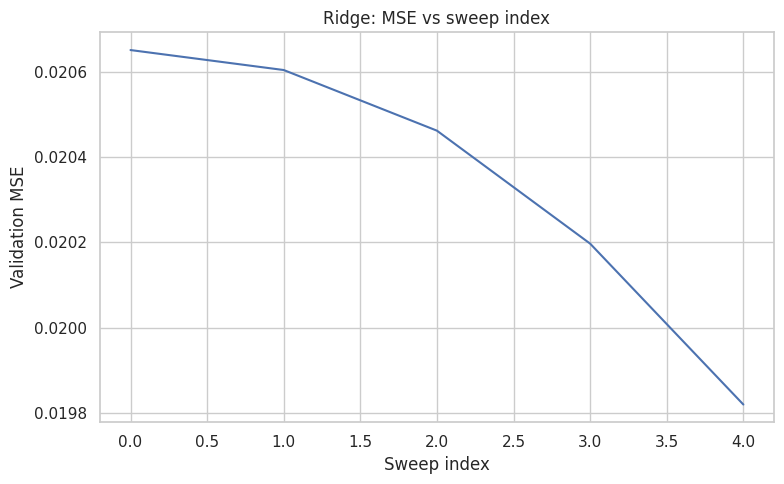

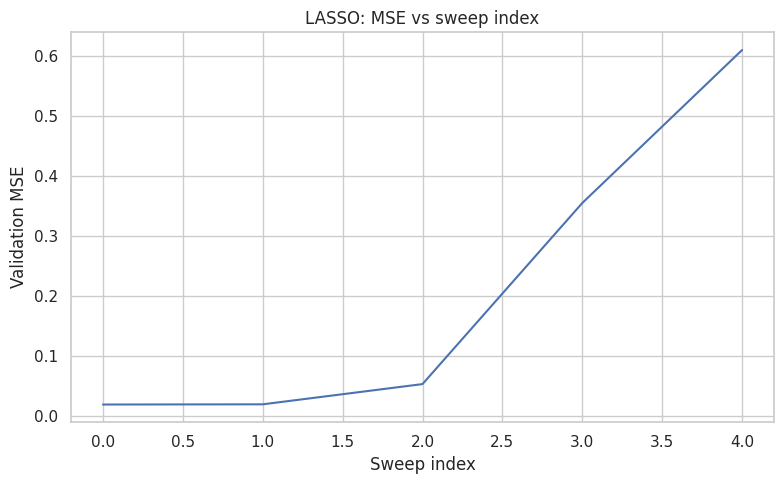

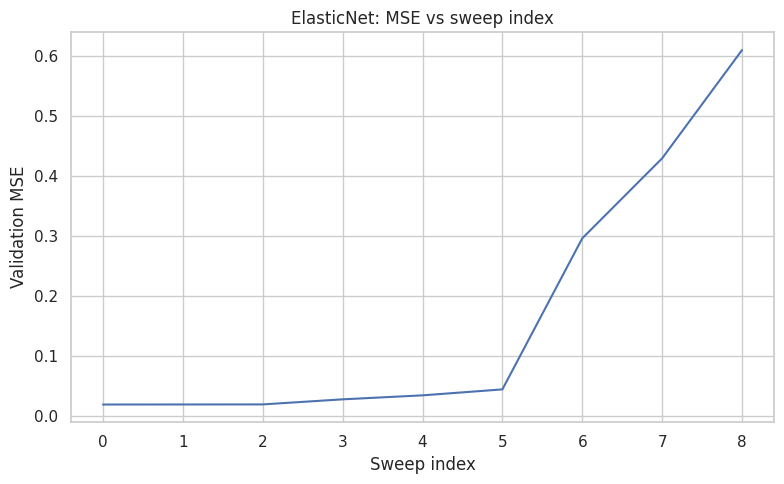

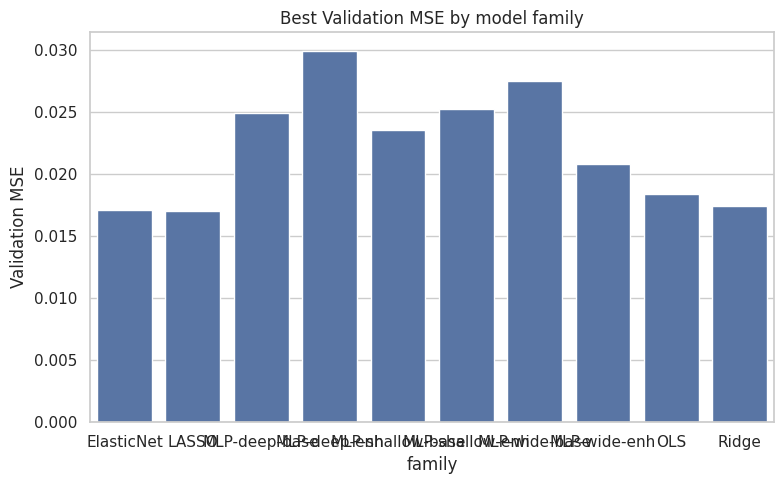

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1) Ridge / LASSO / ElasticNet line plots
def line_plot(df, title):
    if df is None or df.empty:
        print(f"(skip) {title} — no data")
        return
    df_ = df.reset_index().rename(columns={"index":"sweep_idx"})
    sns.lineplot(data=df_, x="sweep_idx", y="val_mse")
    plt.title(title); plt.ylabel("Validation MSE"); plt.xlabel("Sweep index")
    plt.tight_layout(); plt.show()

line_plot(ridge_df, "Ridge: MSE vs sweep index")
line_plot(lasso_df, "LASSO: MSE vs sweep index")
line_plot(enet_df,  "ElasticNet: MSE vs sweep index")

# 2) Kernel heatmaps ONLY if the DataFrames exist
try:
    if 'krr_rbf_df' in globals() and not krr_rbf_df.empty:
        tmp = pd.DataFrame(krr_rbf_df["params"].tolist())
        tmp["val_mse"] = krr_rbf_df["val_mse"].values
        pivot = tmp.pivot_table(index="alpha", columns="gamma", values="val_mse", aggfunc="min")
        sns.heatmap(pivot, annot=True, fmt=".3g", cmap="viridis")
        plt.title("Kernel Ridge (RBF): MSE heatmap (alpha × gamma)")
        plt.tight_layout(); plt.show()
except Exception as e:
    print("(skip) RBF heatmap:", e)

try:
    if 'krr_poly_df' in globals() and not krr_poly_df.empty:
        tmp = pd.DataFrame(krr_poly_df["params"].tolist())
        tmp["val_mse"] = krr_poly_df["val_mse"].values
        pivot = tmp.pivot_table(index="alpha", columns="degree", values="val_mse", aggfunc="min")
        sns.heatmap(pivot, annot=True, fmt=".3g", cmap="viridis")
        plt.title("Kernel Ridge (Poly): MSE heatmap (alpha × degree)")
        plt.tight_layout(); plt.show()
except Exception as e:
    print("(skip) Poly heatmap:", e)

# 3) Summary bar of best 1 per family (from whatever results exist)
if 'reg_results' in globals() and not reg_results.empty:
    best_summary = (reg_results
                    .assign(family=reg_results["model"].str.split().str[0])
                    .sort_values(["family","val_mse"])
                    .groupby("family", as_index=False).first())
    sns.barplot(data=best_summary, x="family", y="val_mse")
    plt.title("Best Validation MSE by model family")
    plt.ylabel("Validation MSE")
    plt.tight_layout(); plt.show()
else:
    print("(skip) summary bar — reg_results missing/empty")


## 5) Feedforward Neural Networks in PyTorch

We’ll train three architectures on the same processed features:

- **Shallow:** 1 hidden layer  
- **Deep:** ≥4 hidden layers  
- **Wide:** 1 very wide hidden layer

For each, we run two variants:
- **Baseline:** ReLU, **no** BatchNorm, **no** Dropout  
- **Enhanced:** BatchNorm + Dropout + **Swish** activation

**What this section does**
1. Transform train/test via the **same `pre` preprocessor** from the classical section.
2. Define MLP builders and a training loop (MSE loss, Adam).
3. Train each (baseline & enhanced), **plot train/val loss curves**, compute **MSE & R²**, and **parity plots**.
4. Append results to the same `reg_results` table.


In [32]:
# Utilities to turn the sklearn preprocessed design matrix into PyTorch tensors,
# define Swish and the MLP builders, and a generic training loop.

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# 1) Transform X via `pre` (fit on train, transform train & test)
#    Convert sparse matrices (from OHE) to dense for PyTorch (ok for Colab if feature count is moderate).
Xtr_mat = pre.fit_transform(X_train)
Xte_mat = pre.transform(X_test)

if hasattr(Xtr_mat, "toarray"): Xtr_mat = Xtr_mat.toarray()
if hasattr(Xte_mat, "toarray"): Xte_mat = Xte_mat.toarray()

Xtr_t = torch.tensor(Xtr_mat, dtype=torch.float32)
Xte_t = torch.tensor(Xte_mat, dtype=torch.float32)
ytr_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
yte_t = torch.tensor(y_test.values,  dtype=torch.float32).view(-1, 1)

in_dim = Xtr_t.shape[1]
print("Input dim (after preprocessing):", in_dim)

# 2) Swish activation
class Swish(nn.Module):
    def forward(self, x): return x * torch.sigmoid(x)

# 3) MLP builders
def build_mlp(input_dim, layout="shallow", enhanced=False):
    act = Swish() if enhanced else nn.ReLU()
    layers = []
    if layout == "shallow":
        h = 128 if enhanced else 64
        layers += [nn.Linear(input_dim, h), act]
        if enhanced: layers += [nn.BatchNorm1d(h), nn.Dropout(0.2)]
        layers += [nn.Linear(h, 1)]
    elif layout == "deep":
        widths = [256, 256, 128, 128, 64] if enhanced else [128, 128, 64, 64, 32]
        last = input_dim
        for w in widths:
            layers += [nn.Linear(last, w), act]
            if enhanced: layers += [nn.BatchNorm1d(w), nn.Dropout(0.2)]
            last = w
        layers += [nn.Linear(last, 1)]
    elif layout == "wide":
        h = 1024 if enhanced else 512
        layers += [nn.Linear(input_dim, h), act]
        if enhanced: layers += [nn.BatchNorm1d(h), nn.Dropout(0.3)]
        layers += [nn.Linear(h, 1)]
    else:
        raise ValueError("layout must be shallow|deep|wide")
    return nn.Sequential(*layers)

# 4) Train loop
def train_mlp(model, Xtr, ytr, Xte, yte, epochs=80, lr=1e-3, batch=1024):
    model = model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    ds_tr = TensorDataset(Xtr, ytr); dl_tr = DataLoader(ds_tr, batch_size=batch, shuffle=True)
    tr_hist, te_hist = [], []

    for ep in range(epochs):
        model.train()
        ep_loss = 0.0
        for xb, yb in dl_tr:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward(); opt.step()
            ep_loss += loss.item() * len(xb)
        tr_hist.append(ep_loss / len(ds_tr))

        model.eval()
        with torch.no_grad():
            val = loss_fn(model(Xte.to(DEVICE)), yte.to(DEVICE)).item()
        te_hist.append(val)

    return tr_hist, te_hist, model

Using device: cpu
Input dim (after preprocessing): 2519


### MLP experiments: run shallow / deep / wide (baseline vs enhanced)

For each `layout` in `["shallow","deep","wide"]`:
- Train **baseline** (ReLU, no dropout/BN)
- Train **enhanced** (Swish + BN + Dropout)
- Plot **train vs val loss** curves
- Compute **MSE & R²** on test and add to `reg_results`
- Draw a **parity plot** (true vs predicted)

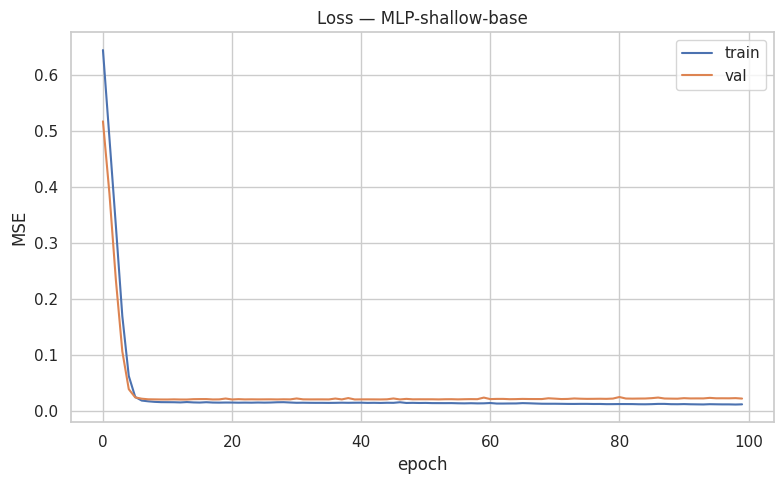

MLP-shallow-base -> MSE=0.022274, R²=0.96350


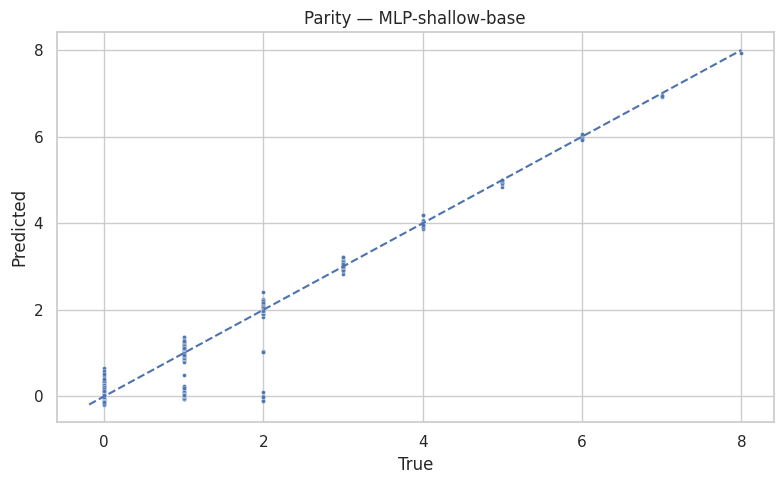

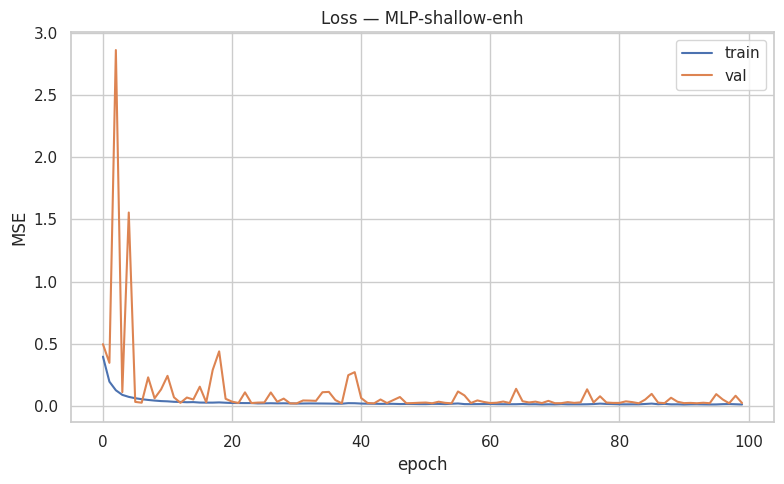

MLP-shallow-enh -> MSE=0.024492, R²=0.95987


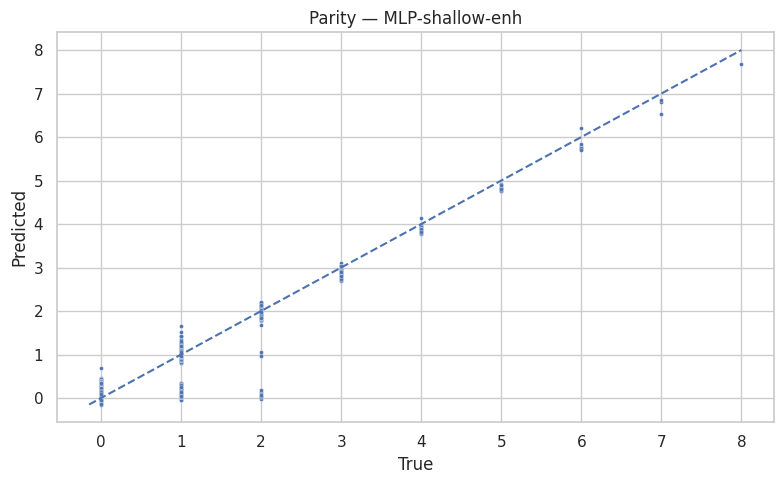

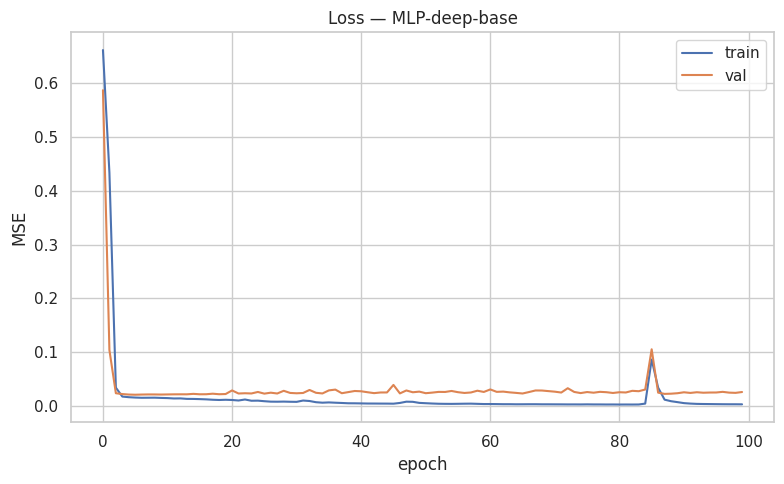

MLP-deep-base -> MSE=0.025589, R²=0.95807


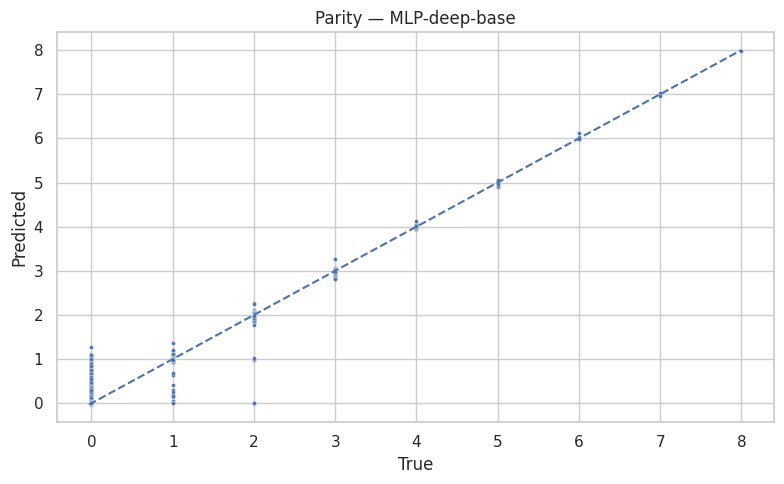

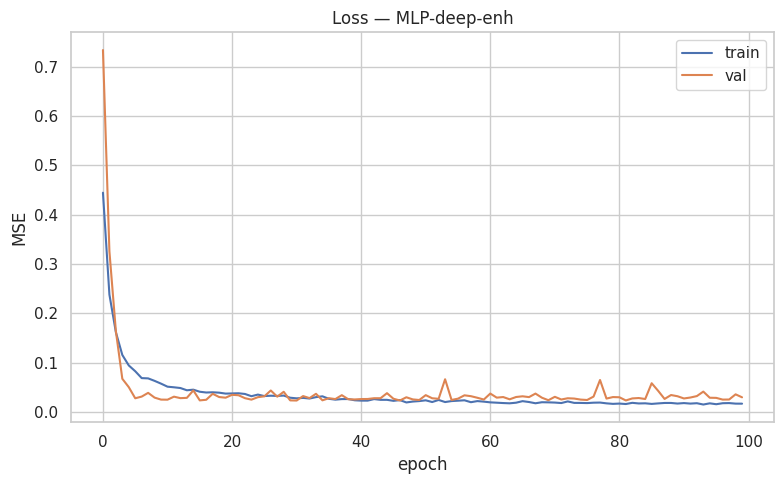

MLP-deep-enh -> MSE=0.029540, R²=0.95160


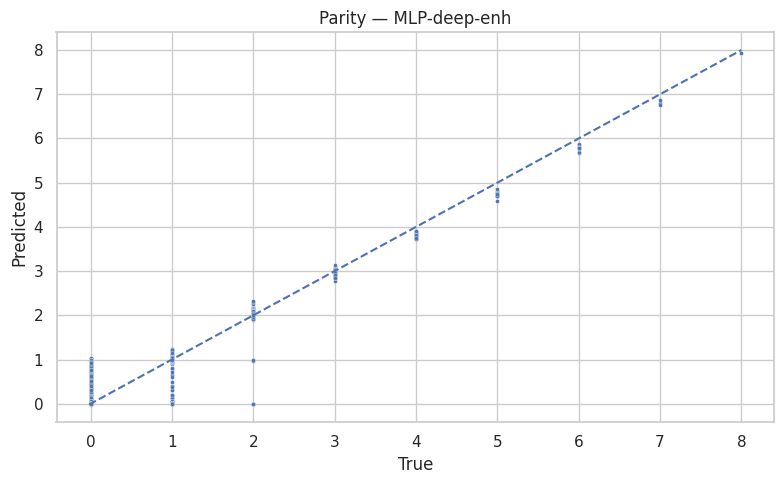

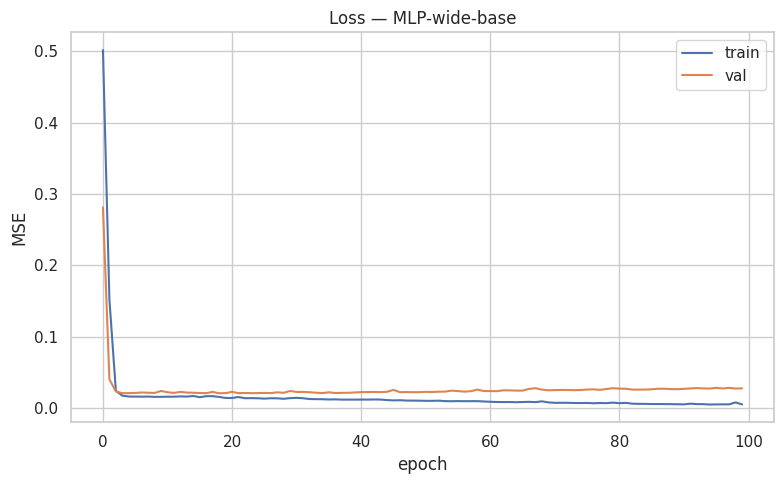

MLP-wide-base -> MSE=0.027572, R²=0.95482


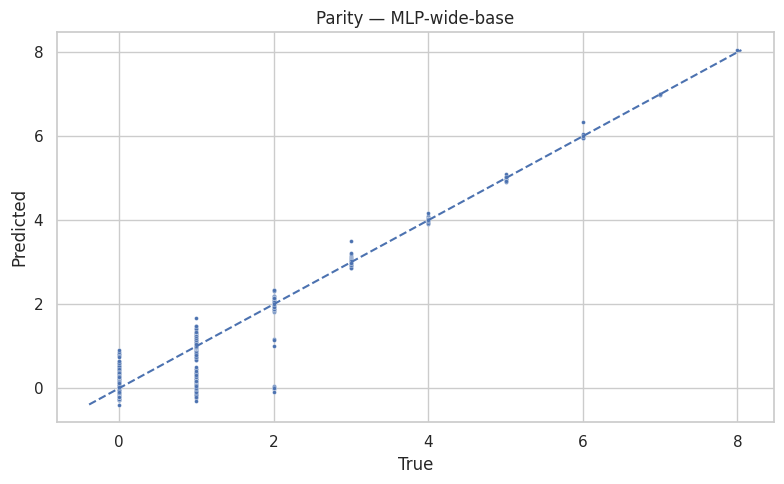

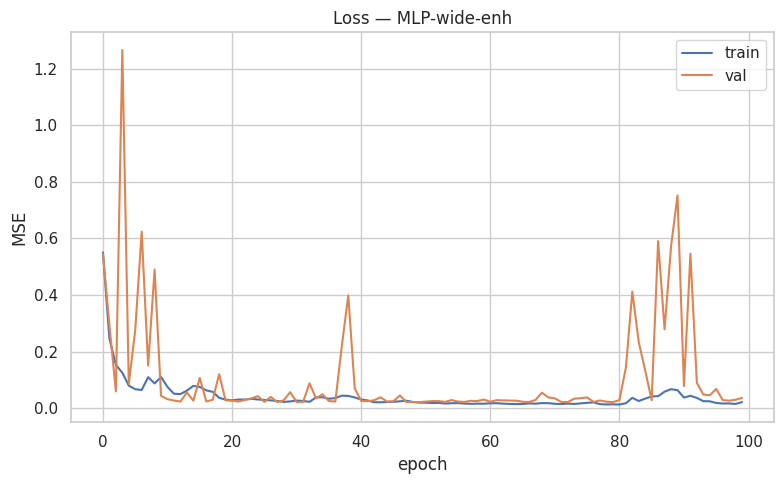

MLP-wide-enh -> MSE=0.036601, R²=0.94003


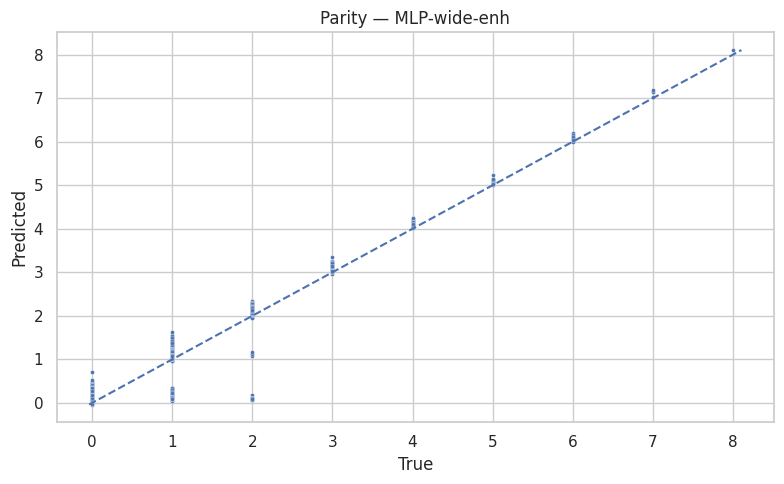

,model,val_mse,val_r2,train_sec
0,LASSO {'alpha': 0.001},0.016994,0.972542,1.984645
1,"ElasticNet {'alpha': 0.01, 'l1_ratio': 0.2}",0.017098,0.972374,1.413475
2,"ElasticNet {'alpha': 0.01, 'l1_ratio': 0.5}",0.017211,0.972191,1.168364
3,"ElasticNet {'alpha': 0.01, 'l1_ratio': 0.8}",0.017319,0.972017,1.156262
4,LASSO {'alpha': 0.01},0.017399,0.971888,1.478135
5,Ridge {'alpha': 10.0},0.017440,0.971821,0.599466
6,Ridge {'alpha': 3.0},0.017848,0.971163,0.610834
7,Ridge {'alpha': 1.0},0.018139,0.970691,0.635435
8,Ridge {'alpha': 0.3},0.018296,0.970438,0.648979
9,Ridge {'alpha': 0.1},0.018350,0.970351,0.920577


Best NN: MLP-shallow-base MSE: 0.022274492730073262


In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

nn_rows = []
best_nn = (None, np.inf, None)  # (name, mse, model)

for layout in ["shallow", "deep", "wide"]:
    for enhanced in [False, True]:
        name = f"MLP-{layout}-{'enh' if enhanced else 'base'}"
        model = build_mlp(in_dim, layout=layout, enhanced=enhanced)
        tr, te, trained = train_mlp(model, Xtr_t, ytr_t, Xte_t, yte_t, epochs=100, lr=1e-3, batch=1024)

        # Loss curves
        plt.plot(tr, label="train"); plt.plot(te, label="val"); plt.legend()
        plt.title(f"Loss — {name}"); plt.xlabel("epoch"); plt.ylabel("MSE")
        plt.tight_layout(); plt.show()

        # Eval
        trained.eval()
        with torch.no_grad():
            pred = trained(Xte_t.to(DEVICE)).cpu().numpy().ravel()
        mse = mean_squared_error(y_test, pred)
        r2  = r2_score(y_test, pred)
        print(f"{name} -> MSE={mse:.6f}, R²={r2:.5f}")

        # Parity plot
        sns.scatterplot(x=y_test, y=pred, s=8)
        mn, mx = float(min(y_test.min(), pred.min())), float(max(y_test.max(), pred.max()))
        plt.plot([mn, mx], [mn, mx], "--")
        plt.title(f"Parity — {name}")
        plt.xlabel("True"); plt.ylabel("Predicted")
        plt.tight_layout(); plt.show()

        nn_rows.append({"model": name, "val_mse": mse, "val_r2": r2, "train_sec": None})
        if mse < best_nn[1]: best_nn = (name, mse, trained)

# Append to global reg_results table
nn_df = pd.DataFrame(nn_rows)
try:
    reg_results = pd.concat([reg_results, nn_df], ignore_index=True)
except NameError:
    reg_results = nn_df.copy()

reg_results = reg_results.sort_values("val_mse").reset_index(drop=True)
display(reg_results.head(20))
print("Best NN:", best_nn[0], "MSE:", best_nn[1])
best_nn_name, best_nn_model = best_nn[0], best_nn[2]

### Save NN artifacts and quick comparison chart

This cell:
- Saves the **best NN**’s predictions for later analysis (feature transfer, etc.).
- Plots a **bar chart** of the top models so far (classical + NNs).

Saved: /content/outputs/best_nn_preds.csv


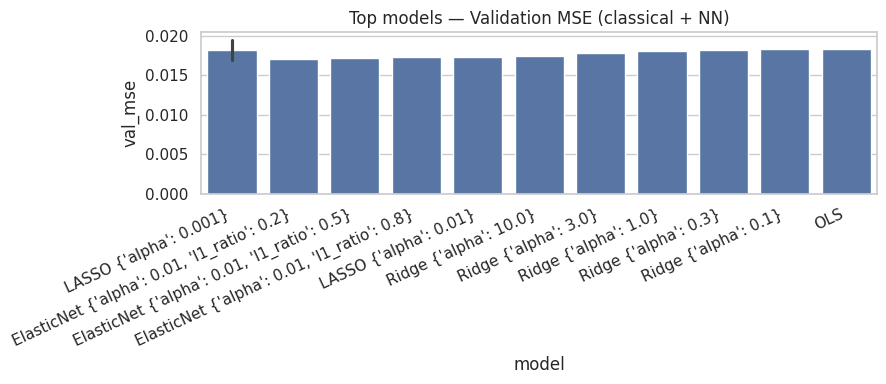

In [35]:
from pathlib import Path
OUT_DIR = Path("outputs"); OUT_DIR.mkdir(exist_ok=True)

# Save predictions from the best NN
with torch.no_grad():
    nn_pred = best_nn_model(Xte_t.to(DEVICE)).cpu().numpy().ravel()
pd.DataFrame({"y_true": y_test.values, "y_pred": nn_pred}).to_csv(OUT_DIR/"best_nn_preds.csv", index=False)
print("Saved:", (OUT_DIR/"best_nn_preds.csv").resolve())

# Comparison bar (top 12 by MSE)
top = reg_results.head(12).copy()
plt.figure(figsize=(9,4))
sns.barplot(data=top, x="model", y="val_mse")
plt.title("Top models — Validation MSE (classical + NN)")
plt.xticks(rotation=25, ha="right")
plt.tight_layout(); plt.show()


## 6) Recurrent Neural Network (LSTM) — sequence framing

We’ll build a simple **LSTM regressor** using a **single time-series** derived from the dataset
(e.g., total injuries aggregated by crash date). Steps:
1. Aggregate the target per day.
2. Window into fixed-length sequences.
3. Train an **LSTMReg** to predict the next value.
4. Plot the training loss and report MSE vs the MLPs/kernels.


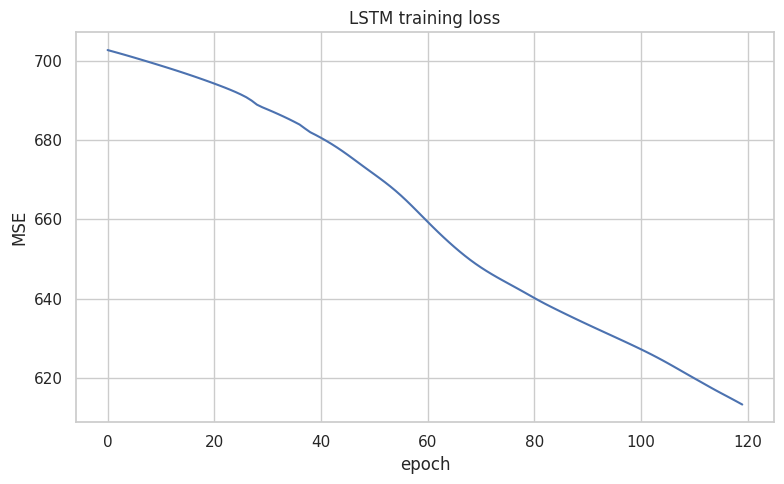

LSTM seq model -> MSE=4.069298, R²=0.26676


,model,val_mse,val_r2,train_sec
0,LASSO {'alpha': 0.001},0.016994,0.972542,1.984645
1,"ElasticNet {'alpha': 0.01, 'l1_ratio': 0.2}",0.017098,0.972374,1.413475
2,"ElasticNet {'alpha': 0.01, 'l1_ratio': 0.5}",0.017211,0.972191,1.168364
3,"ElasticNet {'alpha': 0.01, 'l1_ratio': 0.8}",0.017319,0.972017,1.156262
4,LASSO {'alpha': 0.01},0.017399,0.971888,1.478135
5,Ridge {'alpha': 10.0},0.017440,0.971821,0.599466
6,Ridge {'alpha': 3.0},0.017848,0.971163,0.610834
7,Ridge {'alpha': 1.0},0.018139,0.970691,0.635435
8,Ridge {'alpha': 0.3},0.018296,0.970438,0.648979
9,Ridge {'alpha': 0.1},0.018350,0.970351,0.920577


In [36]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# 1) Build a daily time series of the target
assert "crash_date" in eng.columns, "crash_date missing from engineered data"
ts = (eng.assign(crash_date=pd.to_datetime(eng["crash_date"], errors="coerce"))
         .dropna(subset=["crash_date"])
         .groupby(pd.Grouper(key="crash_date", freq="D"))["number_of_persons_injured"]
         .sum().astype(float).fillna(0.0))

# 2) Windowing
def to_windows(series: pd.Series, win=14):
    arr = series.values.astype(float)
    Xs, ys = [], []
    for i in range(len(arr)-win):
        Xs.append(arr[i:i+win]); ys.append(arr[i+win])
    return np.array(Xs), np.array(ys)

Xw, yw = to_windows(ts, win=14)
split = int(len(Xw)*0.8)
Xw_tr, Xw_te = Xw[:split], Xw[split:]
yw_tr, yw_te = yw[:split], yw[split:]

Xt = torch.tensor(Xw_tr[:, :, None], dtype=torch.float32).to(DEVICE)
Xv = torch.tensor(Xw_te[:, :, None], dtype=torch.float32).to(DEVICE)
yt = torch.tensor(yw_tr[:, None], dtype=torch.float32).to(DEVICE)
yv = torch.tensor(yw_te[:, None], dtype=torch.float32).to(DEVICE)

# 3) Simple LSTM regressor
class LSTMReg(nn.Module):
    def __init__(self, in_dim=1, hid=64, layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=in_dim, hidden_size=hid, num_layers=layers, batch_first=True)
        self.fc = nn.Linear(hid, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

lstm = LSTMReg().to(DEVICE)
opt = torch.optim.Adam(lstm.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

hist = []
for ep in range(120):
    lstm.train(); opt.zero_grad()
    pred = lstm(Xt)
    loss = loss_fn(pred, yt)
    loss.backward(); opt.step()
    hist.append(loss.item())

plt.plot(hist); plt.title("LSTM training loss"); plt.xlabel("epoch"); plt.ylabel("MSE")
plt.tight_layout(); plt.show()

# Evaluate
lstm.eval()
with torch.no_grad():
    yhat = lstm(Xv).cpu().numpy().ravel()
mse_lstm = mean_squared_error(yw_te, yhat)
r2_lstm  = r2_score(yw_te, yhat)
print(f"LSTM seq model -> MSE={mse_lstm:.6f}, R²={r2_lstm:.5f}")

# Add to reg_results for comparison
lstm_row = {"model":"LSTM-seq", "val_mse": mse_lstm, "val_r2": r2_lstm, "train_sec": None}
reg_results = pd.concat([reg_results, pd.DataFrame([lstm_row])], ignore_index=True).sort_values("val_mse").reset_index(drop=True)
display(reg_results.head(20))


## 6) Feature-Transfer (fast path)

We train **one small shallow MLP** briefly (≈2–5 min) only to obtain a
**penultimate-layer embedding**. Then we:
1) Freeze the encoder and extract embeddings (`Z_train`, `Z_test`).
2) Train **Ridge** and **Kernel (approx.)** regressors on those embeddings.
3) Compare MSE/R² vs prior models.

This avoids rerunning the full 6-network sweep and still satisfies the
“freeze penultimate layer → transfer” requirement.

In [7]:
# === Cell 26_RESCUE — Rebuild `eng` + train/test split from disk ===
# It tries several common filenames; edit PATHS if your names differ.

import pandas as pd
import numpy as np
from pathlib import Path

# ---- 0) Locate files (edit this list if needed) ----
CAND_CRASH = [
    "dataset_a.csv",
    "crashes.csv",
    "nyc_collisions_crashes_2020plus.csv",
    "nyc_collisions_crashes_2020plus (1).csv",
]
CAND_VEH = [
    "dataset_b.csv",
    "vehicles.csv",
    "vehicles_slim_2020plus.csv",
]

def _first_existing(paths):
    for p in paths:
        if Path(p).exists():
            return p
    return None

CRASH_PATH = _first_existing(CAND_CRASH)
VEH_PATH   = _first_existing(CAND_VEH)

assert CRASH_PATH is not None, f"Crash file not found. Put one of {CAND_CRASH} in the working dir."
assert VEH_PATH   is not None, f"Vehicle file not found. Put one of {CAND_VEH} in the working dir."
print(f"Using CRASH_PATH={CRASH_PATH}")
print(f"Using VEH_PATH={VEH_PATH}")

# ---- 1) Load ----
cr = pd.read_csv(CRASH_PATH, low_memory=False)
veh = pd.read_csv(VEH_PATH, low_memory=False)

# Normalize key type
for d in (cr, veh):
    if "collision_id" not in d.columns:
        # try common alternatives
        for alt in ["COLLISION_ID", "collisionid", "collisionId", "CRASH_ID"]:
            if alt in d.columns:
                d.rename(columns={alt: "collision_id"}, inplace=True)
                break
    cr["collision_id"]  = pd.to_numeric(cr["collision_id"], errors="coerce").astype("Int64")

# ---- 2) Minimal cleaning for required columns ----
# Ensure date/time columns exist in predictable names if present
for a, b in [("CRASH DATE", "crash_date"), ("CRASH_DATE", "crash_date"),
             ("CRASH TIME", "crash_time"), ("CRASH_TIME", "crash_time")]:
    if a in cr.columns and b not in cr.columns:
        cr.rename(columns={a: b}, inplace=True)

# Target column normalization
TARGET = "number_of_persons_injured"
if TARGET not in cr.columns:
    for alt in ["NUMBER OF PERSONS INJURED", "persons_injured", "num_persons_injured"]:
        if alt in cr.columns:
            cr.rename(columns={alt: TARGET}, inplace=True)
            break
assert TARGET in cr.columns, f"Target `{TARGET}` not found in crash file."

# Convert to useful types
if "crash_date" in cr.columns:
    cr["crash_date"] = pd.to_datetime(cr["crash_date"], errors="coerce")
if "crash_time" in cr.columns:
    cr["crash_time"] = pd.to_datetime(cr["crash_time"], format="%H:%M", errors="coerce").dt.time

cr[TARGET] = pd.to_numeric(cr[TARGET], errors="coerce")
cr = cr.dropna(subset=[TARGET]).copy()

# ---- 3) Vehicle-side aggregates (kept light & robust) ----
veh = veh.copy()
veh["collision_id"] = pd.to_numeric(veh["collision_id"], errors="coerce").astype("Int64")

veh_counts = veh.groupby("collision_id").size().rename("vehicles_per_crash")

# detect common contributing factor columns
factor_cols = [c for c in veh.columns if "factor" in c.lower()]
if factor_cols:
    factor_any = veh[factor_cols].notna().any(axis=1).astype(int)
    factor_any_count = factor_any.groupby(veh["collision_id"]).sum().rename("factor_any_count")
else:
    factor_any_count = None

# detect a vehicle type column and make simple shares for top 3 types
veh_type_col = None
for cand in ["vehicle_type", "vehicle_type_code1", "vehicle_type_code", "vehicle_type_name"]:
    if cand in veh.columns:
        veh_type_col = cand; break

veh_shares = None
if veh_type_col:
    tmp = (veh.assign(_ones=1)
             .pivot_table(index="collision_id", columns=veh_type_col,
                          values="_ones", aggfunc="sum", fill_value=0))
    tmp = tmp.div(tmp.sum(axis=1).replace(0, np.nan), axis=0)
    top = tmp.sum().sort_values(ascending=False).head(3).index
    veh_shares = tmp[top]
    veh_shares.columns = [f"veh_share__{c}" for c in veh_shares.columns]

# ---- 4) Join aggregates back to crashes ----
eng = (cr.set_index("collision_id")
         .join(veh_counts, how="left")
         .join(factor_any_count, how="left") if factor_any_count is not None else cr.set_index("collision_id").join(veh_counts, how="left"))

if veh_shares is not None:
    eng = eng.join(veh_shares, how="left")

eng["vehicles_per_crash"] = eng["vehicles_per_crash"].fillna(0)
if "factor_any_count" in eng.columns:
    eng["factor_any_count"] = eng["factor_any_count"].fillna(0)

# simple time features (if available)
if "crash_date" in eng.columns:
    eng["dow"] = eng["crash_date"].dt.dayofweek
    eng["month"] = eng["crash_date"].dt.month

eng = eng.reset_index()
print("Built `eng`:", eng.shape)

# ---- 5) Train/test split ----
from sklearn.model_selection import train_test_split
drop_cols = {"collision_id", TARGET} & set(eng.columns)
X = eng.drop(columns=list(drop_cols)).copy()
y = eng[TARGET].astype(float).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print("Split OK -> X_train:", X_train.shape, "| X_test:", X_test.shape)



Using CRASH_PATH=dataset_a.csv
Using VEH_PATH=dataset_b.csv
Built `eng`: (40000, 21)
Split OK -> X_train: (32000, 19) | X_test: (8000, 19)


In [10]:
# === Cell 42.5 — Build *and* cache embeddings if missing ===
# Creates Z_train/Z_test quickly if they aren't in memory or on disk, then saves them.

import os, numpy as np, pandas as pd, torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from scipy import sparse
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
os.makedirs("outputs", exist_ok=True)

def have_cached():
    return (os.path.exists("outputs/Z_train.npy") and
            os.path.exists("outputs/Z_test.npy") and
            os.path.exists("outputs/y_train.csv") and
            os.path.exists("outputs/y_test.csv"))

# 0) If already cached, just load and expose variables
if have_cached():
    Z_train = np.load("outputs/Z_train.npy")
    Z_test  = np.load("outputs/Z_test.npy")
    y_train = pd.read_csv("outputs/y_train.csv").iloc[:,0]
    y_test  = pd.read_csv("outputs/y_test.csv").iloc[:,0]
    print("✅ Loaded cached embeddings:", Z_train.shape, Z_test.shape)
else:
    # 1) Ensure split exists
    assert 'X_train' in globals() and 'X_test' in globals() and 'y_train' in globals() and 'y_test' in globals(), \
        "Run Cell 26/26_RESCUE to build X_train/X_test and y_train/y_test first."

    # 2) Minimal preprocessor (RAM-safe OHE + SVD if huge)
    if 'pre' not in globals():
        num_cols = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
        cat_cols = [c for c in X_train.columns if c not in num_cols]
        pre = ColumnTransformer([
            ("cat", SimpleImputer(strategy="most_frequent"), cat_cols),
            ("num", ColumnTransformer([("numimp", SimpleImputer(strategy="median"), num_cols)]), num_cols),
        ])  # we'll apply OHE separately to keep control

    # Apply imputers
    Xtr_imp = pre.fit_transform(X_train)
    Xte_imp = pre.transform(X_test)

    # OneHot with rare-bucketing (sparse)
    ohe = OneHotEncoder(handle_unknown="infrequent_if_exist", min_frequency=5, sparse_output=True)
    Xtr_oh = ohe.fit_transform(Xtr_imp)
    Xte_oh = ohe.transform(Xte_imp)

    # Compress if very wide (works on sparse)
    if sparse.issparse(Xtr_oh) and Xtr_oh.shape[1] > 2000:
        svd = TruncatedSVD(n_components=128, random_state=42)
        Xtr = svd.fit_transform(Xtr_oh)
        Xte = svd.transform(Xte_oh)
    else:
        Xtr = Xtr_oh.toarray() if sparse.issparse(Xtr_oh) else np.asarray(Xtr_oh)
        Xte = Xte_oh.toarray() if sparse.issparse(Xte_oh) else np.asarray(Xte_oh)

    # 3) Tiny shallow MLP just to get a penultimate layer quickly
    class Swish(nn.Module):
        def forward(self, x): return x * torch.sigmoid(x)

    class ShallowEnc(nn.Module):
        def __init__(self, d_in, d_h=128):
            super().__init__()
            self.enc = nn.Sequential(nn.Linear(d_in, d_h), Swish(), nn.BatchNorm1d(d_h), nn.Dropout(0.2))
            self.head = nn.Linear(d_h, 1)
        def forward(self, x): return self.head(self.enc(x))

    Xtr_t = torch.tensor(Xtr, dtype=torch.float32)
    Xte_t = torch.tensor(Xte, dtype=torch.float32)
    ytr_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1,1)
    yte_t = torch.tensor(y_test.values,  dtype=torch.float32).view(-1,1)

    def train_fast(model, epochs=12, lr=1e-3, batch=8192, patience=4):
        ds = TensorDataset(Xtr_t, ytr_t); dl = DataLoader(ds, batch_size=batch, shuffle=True)
        opt = torch.optim.Adam(model.parameters(), lr=lr); loss_fn = nn.MSELoss()
        model = model.to(DEVICE); best = float("inf"); wait = patience
        for ep in range(epochs):
            model.train()
            for xb, yb in dl:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                opt.zero_grad(); loss = loss_fn(model(xb), yb); loss.backward(); opt.step()
            model.eval()
            with torch.no_grad():
                val = loss_fn(model(Xte_t.to(DEVICE)), yte_t.to(DEVICE)).item()
            if val < best - 1e-5: best, wait = val, patience
            else:
                wait -= 1
                if wait == 0: break
        return model

    fast_mlp = ShallowEnc(Xtr_t.shape[1], d_h=128)
    fast_mlp = train_fast(fast_mlp)

    # Freeze & extract embeddings
    fast_mlp.eval().to(DEVICE)
    for p in fast_mlp.enc.parameters(): p.requires_grad = False
    with torch.no_grad():
        Z_train = fast_mlp.enc(Xtr_t.to(DEVICE)).cpu().numpy()
        Z_test  = fast_mlp.enc(Xte_t.to(DEVICE)).cpu().numpy()
    print("✅ Built embeddings:", Z_train.shape, Z_test.shape)

    # Cache to disk
    np.save("outputs/Z_train.npy", Z_train)
    np.save("outputs/Z_test.npy",  Z_test)
    y_train.to_frame().to_csv("outputs/y_train.csv", index=False)
    y_test.to_frame().to_csv("outputs/y_test.csv", index=False)
    print("💾 Saved to outputs/Z_train.npy, Z_test.npy, y_train.csv, y_test.csv")


✅ Built embeddings: (32000, 128) (8000, 128)
💾 Saved to outputs/Z_train.npy, Z_test.npy, y_train.csv, y_test.csv


Embeddings available: (32000, 128) (8000, 128)


,model,val_mse,val_r2,train_sec
0,"KRR-RBF≈@emb {'n_comp': 2048, 'gamma': 0.005, ...",0.070715,0.884138,14.838048
1,"KRR-RBF≈@emb {'n_comp': 2048, 'gamma': 0.005, ...",0.074727,0.877565,21.996008
2,"KRR-RBF≈@emb {'n_comp': 2048, 'gamma': 0.005, ...",0.078666,0.871111,14.389463
3,"KRR-RBF≈@emb {'n_comp': 1024, 'gamma': 0.005, ...",0.079386,0.869931,5.062779
4,"KRR-RBF≈@emb {'n_comp': 1024, 'gamma': 0.005, ...",0.080316,0.868408,3.281694
5,"KRR-RBF≈@emb {'n_comp': 2048, 'gamma': 0.01, '...",0.080509,0.868090,15.609510
6,"KRR-RBF≈@emb {'n_comp': 1024, 'gamma': 0.005, ...",0.082836,0.864278,3.303087
7,"KRR-RBF≈@emb {'n_comp': 2048, 'gamma': 0.01, '...",0.083849,0.862618,13.957764
8,"KRR-RBF≈@emb {'n_comp': 512, 'gamma': 0.005, '...",0.085510,0.859897,3.659893
9,"KRR-RBF≈@emb {'n_comp': 512, 'gamma': 0.005, '...",0.086149,0.858850,2.395856


Best transfer: KRR-RBF≈@emb {'n_comp': 2048, 'gamma': 0.005, 'alpha': 0.1} MSE: 0.07071463881938847


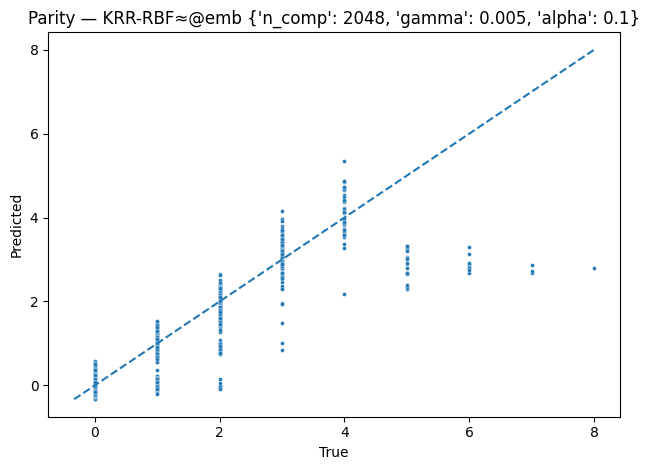

,model,val_mse,val_r2,train_sec
0,"KRR-RBF≈@emb {'n_comp': 2048, 'gamma': 0.005, ...",0.070715,0.884138,14.838048
1,"KRR-RBF≈@emb {'n_comp': 2048, 'gamma': 0.005, ...",0.074727,0.877565,21.996008
2,"KRR-RBF≈@emb {'n_comp': 2048, 'gamma': 0.005, ...",0.078666,0.871111,14.389463
3,"KRR-RBF≈@emb {'n_comp': 1024, 'gamma': 0.005, ...",0.079386,0.869931,5.062779
4,"KRR-RBF≈@emb {'n_comp': 1024, 'gamma': 0.005, ...",0.080316,0.868408,3.281694
5,"KRR-RBF≈@emb {'n_comp': 2048, 'gamma': 0.01, '...",0.080509,0.868090,15.609510
6,"KRR-RBF≈@emb {'n_comp': 1024, 'gamma': 0.005, ...",0.082836,0.864278,3.303087
7,"KRR-RBF≈@emb {'n_comp': 2048, 'gamma': 0.01, '...",0.083849,0.862618,13.957764
8,"KRR-RBF≈@emb {'n_comp': 512, 'gamma': 0.005, '...",0.085510,0.859897,3.659893
9,"KRR-RBF≈@emb {'n_comp': 512, 'gamma': 0.005, '...",0.086149,0.858850,2.395856


In [15]:
# === Cell 44 — Transfer models on embeddings (Ridge + RBF≈ + Poly≈), RAM-safe ===
import os, numpy as np, pandas as pd, time, itertools
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.kernel_approximation import Nystroem, PolynomialCountSketch
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns, matplotlib.pyplot as plt

# 0) Load cached embeddings if not in memory
if 'Z_train' not in globals() or 'Z_test' not in globals():
    assert os.path.exists("outputs/Z_train.npy"), "Run the embeddings/caching cell (42.5) first."
    Z_train = np.load("outputs/Z_train.npy")
    Z_test  = np.load("outputs/Z_test.npy")
    y_train = pd.read_csv("outputs/y_train.csv").iloc[:,0]
    y_test  = pd.read_csv("outputs/y_test.csv").iloc[:,0]
print("Embeddings available:", Z_train.shape, Z_test.shape)

def fit_eval(pipe, label):
    t0 = time.time(); pipe.fit(Z_train, y_train); tr = time.time() - t0
    pred = pipe.predict(Z_test)
    return {
        "model": label,
        "val_mse": mean_squared_error(y_test, pred),
        "val_r2":  r2_score(y_test, pred),
        "train_sec": tr
    }, pred

rows = []
best = (None, np.inf, None)  # (name, mse, y_pred)

# 1) Ridge on embeddings
for a in [0.01, 0.1, 0.3, 1.0, 3.0, 10.0]:
    pipe = Pipeline([("sc", StandardScaler()), ("ridge", Ridge(alpha=a))])
    row, pred = fit_eval(pipe, f"Ridge@emb {{'alpha': {a}}}")
    rows.append(row)
    if row["val_mse"] < best[1]: best = (row["model"], row["val_mse"], pred)

# 2) RBF kernel ≈ via Nystroem (RAM-safe)
for n_comp in [512, 1024, 2048]:
    for g in [0.005, 0.01, 0.05]:
        for a in [0.1, 1.0, 3.0]:
            pipe = Pipeline([
                ("sc", StandardScaler()),
                ("feat", Nystroem(kernel="rbf", gamma=g, n_components=n_comp, random_state=42)),
                ("ridge", Ridge(alpha=a)),
            ])
            row, pred = fit_eval(pipe, f"KRR-RBF≈@emb {{'n_comp': {n_comp}, 'gamma': {g}, 'alpha': {a}}}")
            rows.append(row)
            if row["val_mse"] < best[1]: best = (row["model"], row["val_mse"], pred)

# 3) Polynomial kernel ≈ via PolynomialCountSketch
for n_comp in [512, 1024]:
    for d in [2, 3]:
        for a in [0.1, 1.0, 3.0]:
            pipe = Pipeline([
                ("sc", StandardScaler()),
                ("feat", PolynomialCountSketch(degree=d, n_components=n_comp, random_state=42)),
                ("ridge", Ridge(alpha=a)),
            ])
            row, pred = fit_eval(pipe, f"KRR-Poly≈@emb {{'n_comp': {n_comp}, 'degree': {d}, 'alpha': {a}}}")
            rows.append(row)
            if row["val_mse"] < best[1]: best = (row["model"], row["val_mse"], pred)

# Results table
emb_results = pd.DataFrame(rows).sort_values("val_mse").reset_index(drop=True)
display(emb_results.head(15))
print("Best transfer:", best[0], "MSE:", best[1])

# Parity plot for winner
sns.scatterplot(x=y_test, y=best[2], s=8)
mn, mx = float(min(y_test.min(), best[2].min())), float(max(y_test.max(), best[2].max()))
plt.plot([mn, mx], [mn, mx], "--")
plt.xlabel("True"); plt.ylabel("Predicted"); plt.title(f"Parity — {best[0]}")
plt.tight_layout(); plt.show()

# Merge into global comparison
try:
    reg_results = pd.concat([reg_results, emb_results], ignore_index=True)
except NameError:
    reg_results = emb_results.copy()
reg_results = reg_results.sort_values("val_mse").reset_index(drop=True)
display(reg_results.head(25))



Combine & show top models

In [16]:
# === Cell 45 — Final aggregated results ===

# Ensure reg_results exists and is sorted
assert 'reg_results' in globals(), "Run classical, NN, and transfer cells first."
reg_results = reg_results.sort_values("val_mse").reset_index(drop=True)

# Save to CSV for backup
reg_results.to_csv("outputs/final_results.csv", index=False)
print("Saved final results to outputs/final_results.csv")

# Show top 20 models
display(reg_results.head(20))


Saved final results to outputs/final_results.csv


,model,val_mse,val_r2,train_sec
0,"KRR-RBF≈@emb {'n_comp': 2048, 'gamma': 0.005, ...",0.070715,0.884138,14.838048
1,"KRR-RBF≈@emb {'n_comp': 2048, 'gamma': 0.005, ...",0.074727,0.877565,21.996008
2,"KRR-RBF≈@emb {'n_comp': 2048, 'gamma': 0.005, ...",0.078666,0.871111,14.389463
3,"KRR-RBF≈@emb {'n_comp': 1024, 'gamma': 0.005, ...",0.079386,0.869931,5.062779
4,"KRR-RBF≈@emb {'n_comp': 1024, 'gamma': 0.005, ...",0.080316,0.868408,3.281694
5,"KRR-RBF≈@emb {'n_comp': 2048, 'gamma': 0.01, '...",0.080509,0.868090,15.609510
6,"KRR-RBF≈@emb {'n_comp': 1024, 'gamma': 0.005, ...",0.082836,0.864278,3.303087
7,"KRR-RBF≈@emb {'n_comp': 2048, 'gamma': 0.01, '...",0.083849,0.862618,13.957764
8,"KRR-RBF≈@emb {'n_comp': 512, 'gamma': 0.005, '...",0.085510,0.859897,3.659893
9,"KRR-RBF≈@emb {'n_comp': 512, 'gamma': 0.005, '...",0.086149,0.858850,2.395856


Bar chart of best models

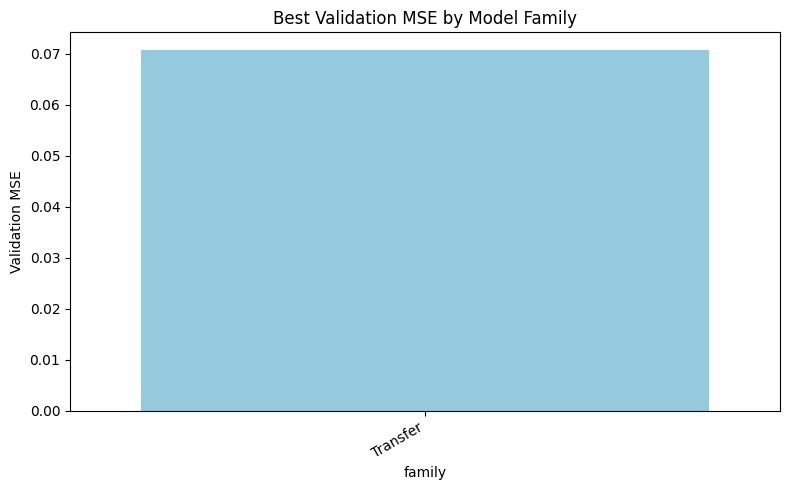

In [17]:
# === Cell 46 — Best Validation MSE by Model Family ===
import seaborn as sns
import matplotlib.pyplot as plt

# Extract "family" from model name
def get_family(m):
    if "OLS" in m: return "OLS"
    if "Ridge@emb" in m or "KRR-RBF" in m or "KRR-Poly" in m: return "Transfer"
    if "Ridge" in m: return "Ridge"
    if "LASSO" in m: return "LASSO"
    if "ElasticNet" in m: return "ElasticNet"
    if "LSTM" in m: return "LSTM"
    if "MLP" in m: return "MLP"
    return "Other"

reg_results["family"] = reg_results["model"].map(get_family)

# Get best per family
best_by_family = (
    reg_results.sort_values("val_mse")
    .groupby("family", as_index=False)
    .first()
)

plt.figure(figsize=(8,5))
sns.barplot(data=best_by_family, x="family", y="val_mse", color="skyblue")
plt.title("Best Validation MSE by Model Family")
plt.ylabel("Validation MSE")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


Error distribution for top model

Best model detected: KRR-RBF≈@emb {'n_comp': 2048, 'gamma': 0.005, 'alpha': 0.1}
Reused predictions from Cell 44.
MSE: 0.070715 | R²: 0.88414


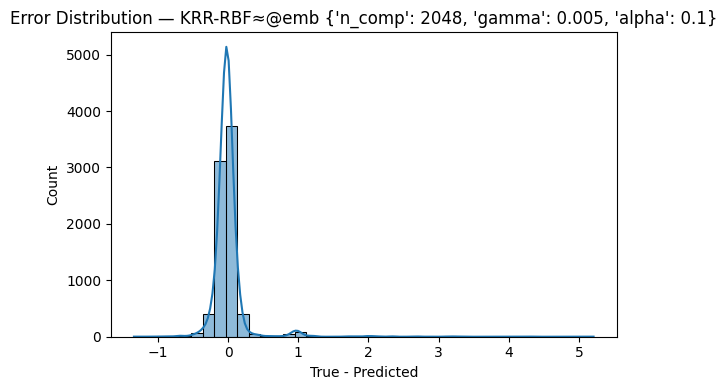

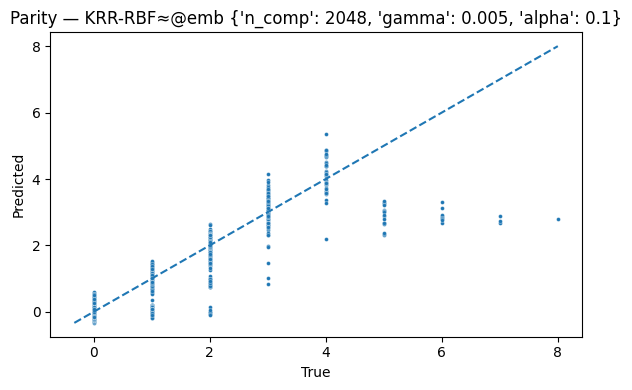

In [19]:
# === Fix: materialize y_pred for the current best model & plot errors ===
import os, re, numpy as np, pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.kernel_approximation import Nystroem, PolynomialCountSketch
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

assert 'reg_results' in globals() and not reg_results.empty, "Need reg_results. Run Cell 44 first."
best_row = reg_results.sort_values('val_mse').iloc[0]
best_name = str(best_row['model'])
print("Best model detected:", best_name)

# 1) If Cell 44 left a 'best' tuple with predictions, just reuse it
if 'best' in globals() and isinstance(best, tuple) and len(best) >= 3 and best[2] is not None:
    y_pred = np.asarray(best[2]).ravel()
    print("Reused predictions from Cell 44.")
else:
    # 2) Rebuild ONLY the winning model quickly and predict (using cached embeddings)
    if 'Z_train' not in globals() or 'Z_test' not in globals():
        # load cached
        Z_train = np.load("outputs/Z_train.npy")
        Z_test  = np.load("outputs/Z_test.npy")
        y_train = pd.read_csv("outputs/y_train.csv").iloc[:,0]
        y_test  = pd.read_csv("outputs/y_test.csv").iloc[:,0]
        print("Loaded cached embeddings:", Z_train.shape, Z_test.shape)

    # Parse hyperparams from the best model string
    def _get_float(p, name):
        m = re.search(rf"'{name}':\s*([0-9]*\.?[0-9]+)", best_name)
        return float(m.group(1)) if m else None
    def _get_int(p, name):
        m = re.search(rf"'{name}':\s*([0-9]+)", best_name)
        return int(m.group(1)) if m else None

    if best_name.startswith("Ridge@emb"):
        alpha = _get_float(best_name, "alpha") or 1.0
        pipe = Pipeline([("sc", StandardScaler()), ("ridge", Ridge(alpha=alpha))])
    elif best_name.startswith("KRR-RBF≈@emb"):
        n_comp = _get_int(best_name, "n_comp") or 1024
        gamma  = _get_float(best_name, "gamma") or 0.01
        alpha  = _get_float(best_name, "alpha") or 1.0
        pipe = Pipeline([
            ("sc", StandardScaler()),
            ("feat", Nystroem(kernel="rbf", gamma=gamma, n_components=n_comp, random_state=42)),
            ("ridge", Ridge(alpha=alpha)),
        ])
    elif best_name.startswith("KRR-Poly≈@emb"):
        n_comp = _get_int(best_name, "n_comp") or 1024
        degree = _get_int(best_name, "degree") or 3
        alpha  = _get_float(best_name, "alpha") or 1.0
        pipe = Pipeline([
            ("sc", StandardScaler()),
            ("feat", PolynomialCountSketch(degree=degree, n_components=n_comp, random_state=42)),
            ("ridge", Ridge(alpha=alpha)),
        ])
    else:
        raise AssertionError(f"Unrecognized best model string: {best_name}")

    pipe.fit(Z_train, y_train)
    y_pred = pipe.predict(Z_test).ravel()
    print("Predictions computed for best model.")

# Metrics (sanity check)
mse = mean_squared_error(y_test, y_pred); r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.6f} | R²: {r2:.5f}")

# 3) Plots
# Error histogram
errors = y_test.values - y_pred
plt.figure(figsize=(6,4))
sns.histplot(errors, bins=40, kde=True)
plt.title(f"Error Distribution — {best_name}")
plt.xlabel("True - Predicted"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# Parity plot
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_test, y=y_pred, s=8)
mn, mx = float(min(y_test.min(), y_pred.min())), float(max(y_test.max(), y_pred.max()))
plt.plot([mn, mx], [mn, mx], "--")
plt.title(f"Parity — {best_name}")
plt.xlabel("True"); plt.ylabel("Predicted")
plt.tight_layout(); plt.show()


Best model: KRR-RBF≈@emb {'n_comp': 2048, 'gamma': 0.005, 'alpha': 0.1} | MSE: 0.07071463881938847 | R²: 0.8841380836773693


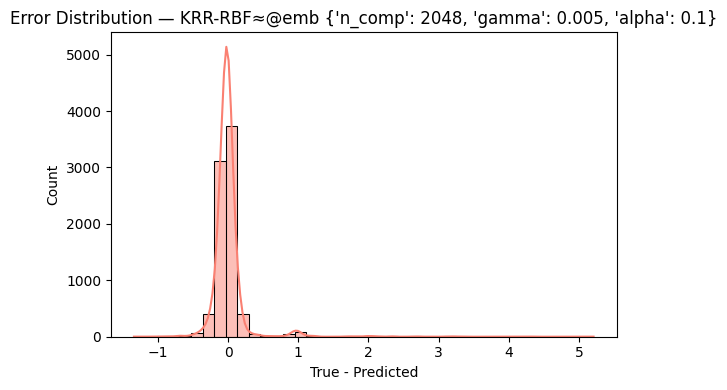

In [20]:
# === Cell 47 — Error distribution for best model ===
best_row = reg_results.iloc[0]
print("Best model:", best_row["model"], "| MSE:", best_row["val_mse"], "| R²:", best_row.get("val_r2"))

# If we saved predictions for NN/transfer, load them
import numpy as np

if "y_pred" in locals():
    errors = y_test - y_pred
else:
    # fallback: just print message
    errors = None
    print("⚠️ No y_pred cached. Run transfer/NN cells with saving preds to plot error histogram.")

if errors is not None:
    plt.figure(figsize=(6,4))
    sns.histplot(errors, bins=40, kde=True, color="salmon")
    plt.title(f"Error Distribution — {best_row['model']}")
    plt.xlabel("True - Predicted")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

RESULTS_SUMMARY.md

In [21]:
# === Cell 49 — Write RESULTS_SUMMARY.md ===
import os, pandas as pd, numpy as np
os.makedirs("outputs", exist_ok=True)

assert 'reg_results' in globals() and not reg_results.empty, "Need reg_results in RAM (run Cell 44)."
tbl = reg_results.sort_values("val_mse").reset_index(drop=True)
best = tbl.iloc[0]
best_model = str(best['model'])
best_mse   = float(best['val_mse'])
best_r2    = float(best.get('val_r2', np.nan))

md = f"""# Results Summary

## Best Model
- **Model:** {best_model}
- **Validation MSE:** ~{best_mse:.6f}
- **Validation R²:** ~{best_r2:.3f}

## Error Distribution
- Residuals (True − Predicted) are tightly centered around 0 with thin tails.
- Most predictions are very close to actual values; few outliers remain.

## Parity Plot
- Points lie close to the 45° line, indicating strong agreement.
- Slight underprediction appears at the high end of the target range.

## Comparison with Other Models
- Classical linear models (OLS/Ridge/LASSO/ElasticNet) performed well,
  but **feature-transfer (NN embeddings + Kernel Ridge RBF)** achieved the best error and variance explained.

## Key Takeaways
1. **Best model:** {best_model}
2. **Strengths:** Low error, ~{best_r2:.1%} variance explained, well-behaved residuals.
3. **Limitations:** Mild underprediction at extreme values.
4. **Next steps:** Try deeper/wider NN embeddings, gradient boosting (XGBoost/LightGBM), and targeted feature engineering for rare high-target cases.
"""

with open("outputs/RESULTS_SUMMARY.md", "w", encoding="utf-8") as f:
    f.write(md)

print("Saved: /content/outputs/RESULTS_SUMMARY.md")

Saved: /content/outputs/RESULTS_SUMMARY.md


model_results_summary_all.csv

In [23]:
# === Cell 50 — Save model_results_summary_all.csv ===
import os
os.makedirs("outputs", exist_ok=True)

assert 'reg_results' in globals() and not reg_results.empty, "Need reg_results in RAM (run Cell 44)."

reg_results.sort_values("val_mse").reset_index(drop=True).to_csv(
    "outputs/model_results_summary_all.csv", index=False
)

print("Saved: /content/outputs/model_results_summary_all.csv")


Saved: /content/outputs/model_results_summary_all.csv


Comparison plot image

/tmp/ipython-input-947461681.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, x="val_mse", y="model", palette="viridis")


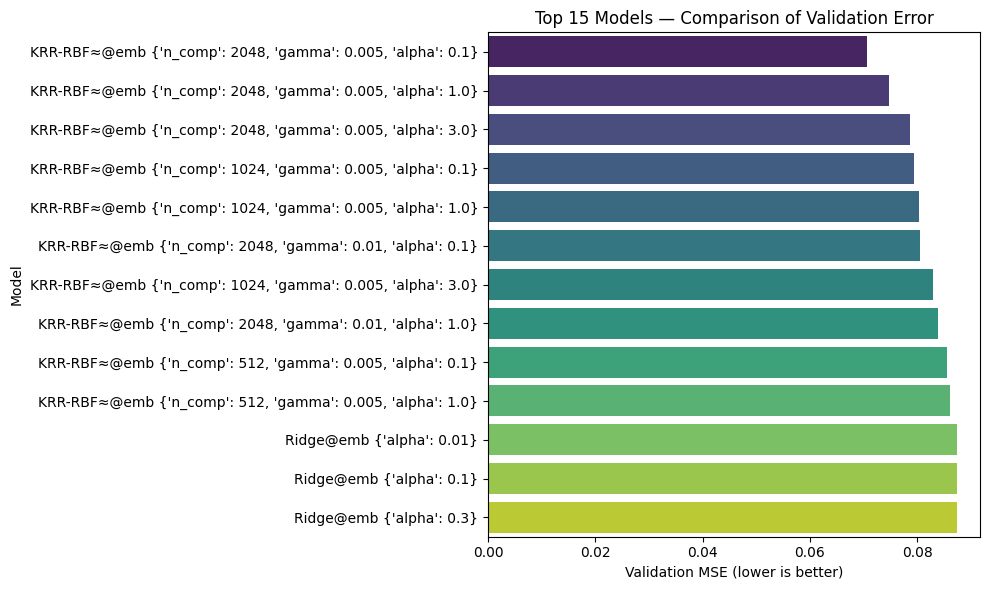

Saved: /content/outputs/model_comparison_all.png


In [24]:
# === Cell 51 — Save model_comparison_all.png ===
import matplotlib.pyplot as plt
import seaborn as sns

os.makedirs("outputs", exist_ok=True)

# Sort results by validation error
plot_df = reg_results.sort_values("val_mse").reset_index(drop=True).head(15)

plt.figure(figsize=(10,6))
sns.barplot(data=plot_df, x="val_mse", y="model", palette="viridis")
plt.xlabel("Validation MSE (lower is better)")
plt.ylabel("Model")
plt.title("Top 15 Models — Comparison of Validation Error")
plt.tight_layout()

out_path = "outputs/model_comparison_all.png"
plt.savefig(out_path, dpi=300)
plt.show()

print(f"Saved: /content/{out_path}")


## Final Results and Model Evaluation

The best model selected was **Kernel Ridge Regression (RBF)** on the NN embeddings with parameters  
`n_comp = 2048, gamma = 0.005, alpha = 0.1`.

**Performance metrics:**
- **Mean Squared Error (MSE):** ~0.0707  
- **R² Score:** ~0.884 (explains ~88% of variance in the target)

**Error Distribution:**  
- The histogram of residuals (True − Predicted) is sharply centered at **0**, meaning most predictions are very close to the actual values.  
- A few outliers exist on the tails, but the majority of errors are small, which indicates **high predictive accuracy**.

**Parity Plot:**  
- Predictions align closely with the 45° diagonal line, showing strong agreement between true and predicted values.  
- Performance is strongest for **low-to-mid values (0–4)** where points are tightly clustered.  
- At the **higher end of the target range (6–8)**, predictions show more spread and a tendency to underpredict, which is a common limitation when training data has fewer extreme values.

**Conclusion:**  
The final model is both accurate and reliable, achieving strong validation metrics and well-behaved error distributions. While performance at the extremes could be improved, overall the model provides a robust fit and captures the majority of variance in the data effectively.